# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [5]:
# all import statements needed for the project, for example:
import os
import bs4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import sqlalchemy as db
from sqlalchemy import text
from bs4 import BeautifulSoup
import re
from datetime import datetime
from typing import List
!pip install geopandas
import geopandas as gpd
import math
import numpy as np
import sqlite3
import scipy.stats as stats
from sqlalchemy import create_engine
from scipy.stats import norm
from typing import Union

In [7]:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = r"./taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = r"./raw_weather_data"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [9]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### 1.1 Load Taxi Zones

#### 1.1.1 Loading the taxi_zone shapefile

In [15]:
def load_taxi_zones(shapefile):
    """
    Load taxi zones data from a shapefile.

    Parameters:
    shapefile (str): The file path to the taxi zones shapefile.

    Returns:
    GeoDataFrame: A GeoPandas GeoDataFrame containing the taxi zones data if loading is successful.
                  Returns None if an error occurs.
    """
    try:
        # Attempt to load the shapefile into a GeoPandas GeoDataFrame
        taxi_zones = gpd.read_file(shapefile)

        # Print a success message with the number of zones loaded
        print(f"Taxi Zones data loaded successfully. Total zones: {len(taxi_zones)}")

        # Return the loaded GeoDataFrame
        return taxi_zones
    except Exception as e:
        # Handle any errors that occur during loading and print the error message
        print(f"Error loading Taxi Zones shapefile: {e}")

        # Return None to indicate failure
        return None

#### 1.1.2 Look up the latitude and longitude for a given Taxi Zone location ID and return  latitude, longitude of location ID

In [25]:
def lookup_coords_for_taxi_zone_id(
    zone_loc_id: int, 
    loaded_taxi_zones: gpd.GeoDataFrame
): 
    """
    Look up the coordinates (latitude and longitude) for a given taxi zone Location ID.

    Parameters:
    zone_loc_id (int): The Location ID of the taxi zone to look up.
    loaded_taxi_zones (gpd.GeoDataFrame): A GeoPandas GeoDataFrame containing taxi zone geometries and attributes.

    Returns:
    Optional[Tuple[float, float]]: A tuple (latitude, longitude) of the centroid of the taxi zone geometry if found.
                                   Returns None if the Location ID is not found or an error occurs.
    """
    try:
        # Convert the GeoDataFrame to the WGS84 coordinate reference system (EPSG:4326).
        loaded_taxi_zones = loaded_taxi_zones.to_crs(epsg=4326)

        # Find the row corresponding to the provided Location ID.
        zone = loaded_taxi_zones.loc[loaded_taxi_zones['LocationID'] == zone_loc_id]
        
        # If no match is found, return None.
        if zone.empty:
            print(f"Location ID {zone_loc_id} not found.")
            return None
        
        # Extract the longitude and latitude of the zone's centroid.
        lon = zone.geometry.centroid.x.values[0]
        lat = zone.geometry.centroid.y.values[0]
        
        # Return the coordinates as a tuple.
        return lat, lon

    except Exception as e:
        # Handle any exceptions and print an error message.
        print(f"Error occurred while looking up coordinates: {e}")
        return None

#### 1.1.3 Downloading coordinates of Taxi Zone  to csv file

In [28]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    """
    Look up the coordinates (latitude and longitude) for a given taxi zone Location ID.

    Parameters:
    zone_loc_id (int): The Location ID of the taxi zone to look up.
    loaded_taxi_zones (GeoDataFrame): A GeoPandas GeoDataFrame containing taxi zone geometries and attributes.

    Returns:
    tuple: A tuple (latitude, longitude) representing the coordinates of the centroid of the taxi zone.
           Returns None if the Location ID is not found or an error occurs.
    """

    try:
        # Convert the GeoDataFrame's coordinate reference system (CRS) to WGS84 (EPSG:4326)
        # which uses latitude and longitude. This ensures consistency in geographic coordinates.
        loaded_taxi_zones = loaded_taxi_zones.to_crs(epsg=4326)

        # Filter the GeoDataFrame to find the row corresponding to the specified Location ID.
        zone = loaded_taxi_zones.loc[loaded_taxi_zones['LocationID'] == zone_loc_id]
        
        # Check if the filtered GeoDataFrame is empty, indicating the Location ID was not found.
        if zone.empty:
            print(f"Location ID {zone_loc_id} not found.")
            return None  # Return None if no matching Location ID exists.
        
        # Calculate the longitude (x) and latitude (y) of the centroid of the zone's geometry.
        lon = zone.geometry.centroid.x.values[0]
        lat = zone.geometry.centroid.y.values[0]
        
        # Return the coordinates as a tuple (latitude, longitude).
        return lat, lon

    except Exception as e:
     
        print(f"Error occurred while looking up coordinates: {e}")
        return None

### 1.2 Calculate Sample Size

In [31]:
def calculate_sample_size(population, confidence_level=0.95, margin_of_error=0.05, proportion=0.5):

    z_scores = {
        0.90: 1.645,
        0.95: 1.96,
        0.99: 2.576
    }   
    # Get the Z-score for the desired confidence level
    Z = z_scores.get(confidence_level, 1.96)  # Default to 95% confidence if not found
    
    # Cochran's sample size formula (n0)
    n0 = (Z ** 2 * proportion * (1 - proportion)) / (margin_of_error ** 2)
    
    # Adjust for finite population if necessary
    if population < 1000:  # If population is small, apply finite population correction
        n = n0 / (1 + (n0 - 1) / population)
    else:
        n = n0
    
    return math.ceil(n)  # Round up to ensure the sample size is sufficient


### 1.2 Common Functions : YELLOW TAXI

##### 1.2.1 Defining get_taxi_html funtion to get the content from NewYork Taxi Trip Reports

In [72]:
def get_taxi_html() -> str:
    response = requests.get(TAXI_URL)
    response.raise_for_status()
    html = response.content
    return html


##### 1.2.2. The function to find the parquet links of  the Only Yellow Taxi trip

In [75]:
def find_taxi_parquet_links() -> List[str]:
    """
    Find and filter links to Yellow Taxi Trip parquet files.

    Returns:
    List[str]: A list of URLs pointing to Yellow Taxi Trip parquet files, filtered by date.
    """
    # Fetch the HTML content from the target website
    html = get_taxi_html()  # Assumes get_taxi_html() retrieves the HTML of the webpage.

    # Parse the HTML content using BeautifulSoup
    soup = bs4.BeautifulSoup(html, "html.parser")

    # Find all <a> tags with the specified "title" attribute (Yellow Taxi Trip Records).
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    
    # Store all the matching <a> tags (in this case, it's the same as yellow_a_tags).
    all_a_tags = yellow_a_tags

    # Extract and clean the 'href' attributes for links containing ".parquet".
    parquet_links = [
        a["href"].strip() for a in all_a_tags if ".parquet" in (a.get("href") or "")
    ]

    # Filter the list of links by date (assumes filter_links_by_date() applies date-based filtering).
    return filter_links_by_date(parquet_links)

##### 1.2.3 The function to filter required dates for our Project's data

In [78]:
def filter_links_by_date(links: List[str]) -> List[str]:
    """
    Filter Parquet file links by date, retaining only those within the specified range.

    Parameters:
    links (List[str]): A list of Parquet file URLs to filter.

    Returns:
    List[str]: A filtered list of links that fall within the specified date range.
    """
    filtered_links = []  # Initialize an empty list to store valid links.
    
    # Define a regex pattern to extract the year and month from the filename.
    # Example match: "_2024-03.parquet" captures 2024 as the year and 03 as the month.
    date_pattern = re.compile(r"_(\d{4})-(\d{2})\.parquet")
    
    for link in links:
        # Search for the date pattern in the link.
        match = date_pattern.search(link)
        if match:
            # Extract the year and month from the matched pattern.
            year, month = int(match.group(1)), int(match.group(2))

            # Create a datetime object for the extracted date.
            file_date = datetime(year, month, 1)

            # Check if the file date falls within the global START_DATE and END_DATE range.
            if START_DATE <= file_date <= END_DATE:
                # Add the link to the filtered list if it meets the criteria.
                filtered_links.append(link)
    
   
    return filtered_links

##### 1.2.4 In our project we are working on the data from Jan/01/2020 till Aug/31/2024

In [81]:
TAXI_URL: str = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Date range for filtering
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime(2024, 8, 30)

##### 1.2.5 Function to Download the Yellow Taxi Data one time. If there is folder and data, this function will skip downloading for next time

In [84]:
def download_files(links: List[str], folder_name: str) -> None:
    """Download files from a list of links and save them to the specified folder."""
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"}
    
    for link in links:
        file_name = link.split("/")[-1]
        file_path = os.path.join(folder_name, file_name)
        print(f"Downloading {file_name} from {link}...")
        if os.path.exists(file_path):
            print(f"File {file_name} already exists. Skipping download.")
            continue  # Skip to the next file if it already exists
        
        print(f"Downloading {file_name} from {link}...")
        
        # Request with headers to mimic a browser
        response = requests.get(link, headers=headers)
        response.raise_for_status()  # Check if download was successful
        
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")


##### 1.2.6 Downloading the Yellow Taxi Parquet files 

In [87]:
# Find and download filtered links
filtered_links =find_taxi_parquet_links()
download_files(filtered_links, "yellow_taxi")


File yellow_tripdata_2024-01.parquet already exists. Skipping download.
File yellow_tripdata_2024-02.parquet already exists. Skipping download.
File yellow_tripdata_2024-03.parquet already exists. Skipping download.
File yellow_tripdata_2024-04.parquet already exists. Skipping download.
File yellow_tripdata_2024-05.parquet already exists. Skipping download.
File yellow_tripdata_2024-06.parquet already exists. Skipping download.
File yellow_tripdata_2024-07.parquet already exists. Skipping download.
File yellow_tripdata_2024-08.parquet already exists. Skipping download.
File yellow_tripdata_2023-01.parquet already exists. Skipping download.
File yellow_tripdata_2023-02.parquet already exists. Skipping download.
File yellow_tripdata_2023-03.parquet already exists. Skipping download.
File yellow_tripdata_2023-04.parquet already exists. Skipping download.
File yellow_tripdata_2023-05.parquet already exists. Skipping download.
File yellow_tripdata_2023-06.parquet already exists. Skipping do

#### 1.2.7  Sampling the Yellow Taxi Parquet Files

##### 1.2.7.1 Creating and checking the folder which will include the Sampled Yellow Taxi parquets. 

In [89]:
folder_path = r"./yellow_taxi"
sample_folder_path = r"./Sample Yellow Taxi"

# Function to create folder if it doesn't exist
def create_folder_if_not_exists(folder_path: str) -> None:
    """
    Create a folder if it does not already exist.

    Parameters:
    folder_path (str): The path of the folder to create.

    Returns:
    None
    """
    # Check if the folder exists using os.path.exists.
    if not os.path.exists(folder_path):
        # If the folder does not exist, create it using os.makedirs.
        os.makedirs(folder_path)  
        print(f"Folder created: {folder_path}")  # Notify that the folder was created.
    else:
        
        print(f"Folder already exists: {folder_path}")

##### 1.2.7.2 The Function to sample each month parquet file based on the Cochran's Sample size formula. In this project, I assume that confidence level of sample is 0.99 and margin of error is 0.05

In [92]:
def process_and_sample_file(file_path: str, sample_folder_path: str):
    """Read a Parquet file, calculate sample size, and save sampled data to a new file."""
    file_name = os.path.basename(file_path)
    sample_file_name = f"sampled_{file_name}"
    sample_file_path = os.path.join(sample_folder_path, sample_file_name)

    # Check if the sample file already exists
    if os.path.exists(sample_file_path):
        print(f"Sample file {sample_file_name} already exists. Skipping this file.")
        return

    # Read the Parquet file
    month_data = pd.read_parquet(file_path)

    # Get the population size
    population_size = len(month_data)

    # Calculate the sample size
    sample_size = calculate_sample_size(population_size, confidence_level=0.99, margin_of_error=0.05)

    # Sample the data
    sampled_data = month_data.sample(n=sample_size, random_state=42)  # Ensure reproducibility

    # Save the sampled data to a new Parquet file
    sampled_data.to_parquet(sample_file_path)

    # Print the results for the file
    print(f"File: {file_name}")
    print(f"Population size: {population_size}")
    print(f"Sample size: {sample_size}")
    print(f"Sampled data saved to: {sample_file_path}")
    print("-" * 40)

##### 1.2.7.3 Downloading the Each month's parquet file of Sample Yellow Taxi 

In [95]:
create_folder_if_not_exists(sample_folder_path)


for file_name in os.listdir(folder_path):
    if file_name.endswith(".parquet"):  # Process only Parquet files
        file_path = os.path.join(folder_path, file_name)
        process_and_sample_file(file_path, sample_folder_path)

Folder already exists: ./Sample Yellow Taxi
Sample file sampled_yellow_tripdata_2020-01.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-02.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-03.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-04.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-05.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-06.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-07.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-08.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-09.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-10.parquet already exists. Skipping this file.
Sample file sampled_yellow_tripdata_2020-11.parquet already exists. Skipping

### 1.3 Common Functions : UBER 

##### 1.3.1 Function to filter the FHVHV parquet files from the URL

In [99]:
def find_fhvhv_parquet_links() -> List[str]:
    """
    Find and filter links to FH and FHVHV Parquet files.

    Returns:
    List[str]: A list of URLs pointing to FH and FHVHV Parquet files, filtered by date.
    """
    # Fetch the HTML content from the target website.
    html = get_taxi_html()  # Assumes get_taxi_html() retrieves the HTML content of the webpage.

    # Parse the HTML content using BeautifulSoup for easy extraction of elements.
    soup = bs4.BeautifulSoup(html, "html.parser")

    # Find all <a> tags where the href attribute matches the regex pattern for 'fhvhv*.parquet'.
    hvfhv_a_tags = soup.find_all(
        "a", href=re.compile(r"fhvhv.*\.parquet", re.IGNORECASE)
    )
    
    # Extract and clean the 'href' attributes from the matching <a> tags.
    parquet_links = [
        a["href"].strip() for a in hvfhv_a_tags if ".parquet" in (a.get("href") or "")
    ]
    
    # Filter the extracted links by date.
    return filter_links_by_date(parquet_links)

##### 1.3.2 Function to download the FHVHV parquet files 

In [102]:
def download_files(links: List[str], folder_name: str) -> None:
    """Download files from a list of links and save them to the specified folder."""
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"}
    
    for link in links:
        file_name = link.split("/")[-1]
        file_path = os.path.join(folder_name, file_name)
        print(f"Downloading {file_name} from {link}...")

        if os.path.exists(file_path):
            print(f"File {file_name} already exists. Skipping download.")
            continue  # Skip to the next file if it already exists
        
        response = requests.get(link, headers=headers)
        response.raise_for_status()  # Check if download was successful
        
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")

##### 1.3.3 Getting the Required FHVHV parquit link from Jan.01.2020 to Aug.31.2024 

In [105]:
filtered_links = find_fhvhv_parquet_links ()
download_files(filtered_links, "fhvhv_raw")

File fhvhv_tripdata_2024-01.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-02.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-03.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-04.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-05.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-06.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-07.parquet already exists. Skipping download.
File fhvhv_tripdata_2024-08.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-01.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-02.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-03.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-04.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-05.parquet already exists. Skipping download.
File fhvhv_tripdata_2023-06.parquet already exists. Skipping download.
File f

#### 1.3.4 Filter out Non Uber Trip from the FHVHV parquet files

##### 1.3.4.5 Guiding from which folder this function will work and to which folder to save the Non Uber Trip parquet files

In [109]:
SOURCE_FOLDER = r"./fhvhv_raw"
OUTPUT_FOLDER = r"./processed_uber_data"

In [111]:
def ensure_output_folder(output_folder: str) -> None:
    """
    Ensure the output folder exists. If not, create it.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output folder: {output_folder}")
    else:
        print(f"The folder '{output_folder}' already exists.")

ensure_output_folder(OUTPUT_FOLDER)

The folder './processed_uber_data' already exists.


In [113]:
def list_parquet_files(folder: str) -> list:
    """
    List all Parquet files in the specified folder.
    """
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.parquet')]

# Get the list of Parquet files
parquet_files = list_parquet_files(SOURCE_FOLDER)


##### 1.3.4.6 The Function to filder the UBER trip data. If the license_num in FHVHV files  is HV0003, this indicates it is Uber Trip. 

In [116]:
def process_parquet_file(file_path: str, output_folder: str) -> str:
    """
    Process a single Parquet file:
    - Filter rows where 'hvfhs_license_num' is 'HV0003'.
    - Save the filtered data to a new file with a modified name.
    """
    # Extract the part of the filename after "fhvhv" to create the new file name
    base_name = os.path.basename(file_path)  # Extracts the filename with extension
    new_file_name = f"uber_{base_name.split('fhvhv')[-1]}"  # Create new filename with "uber_" prefix
    output_file_path = os.path.join(output_folder, new_file_name)  # Full output path

    # Skip if the output file already exists
    if os.path.exists(output_file_path):
        return f"Output file {output_file_path} already exists. Skipping processing for {file_path}."

    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)

    # Filter rows where 'hvfhs_license_num' is 'HV0003'
    filtered_df = df[df['hvfhs_license_num'] == 'HV0003']

    # Save the filtered DataFrame to a new Parquet file
    filtered_df.to_parquet(output_file_path)

    return f"Filtered data from {file_path} saved to {output_file_path}"

In [118]:
results = []
for file_path in parquet_files:
    result = process_parquet_file(file_path, OUTPUT_FOLDER)
    results.append(result)


for result in results:
    print(result)

Output file ./processed_uber_data\uber__tripdata_2020-01.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-01.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-02.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-02.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-03.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-03.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-04.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-04.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-05.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-05.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-06.parquet already exists. Skipping processing for ./fhvhv_raw\fhvhv_tripdata_2020-06.parquet.
Output file ./processed_uber_data\uber__tripdata_2020-07.parquet already exists. Skipping processing for .

#### 1.3.5 SAMPLE the UBER trips 

##### 1.3.6 Using the above functions used for sampling Yellow Taxi trips. We used same function to Sample Filtered Uber trips

In [122]:
uber_folder_path = r"./processed_uber_data"
uber_sample_folder_path = r"./Sample Uber Data"

In [124]:
create_folder_if_not_exists(uber_sample_folder_path)
for file_name in os.listdir(uber_folder_path):
    if file_name.endswith(".parquet"):  # Process only Parquet files
        file_path = os.path.join(uber_folder_path, file_name)
        process_and_sample_file(file_path, uber_sample_folder_path)

Folder already exists: ./Sample Uber Data
Sample file sampled_uber__tripdata_2020-01.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-02.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-03.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-04.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-05.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-06.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-07.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-08.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-09.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-10.parquet already exists. Skipping this file.
Sample file sampled_uber__tripdata_2020-11.parquet already exists. Skipping this file.
S

### 1.4 Process Taxi Data

##### 1.4.1 This function filters the data on one month's url. For the required column we only choose the required column for our future data analysis. Also, We did Column Normalization that Columns of "Airport_fee" is wrotten diffent before and after 2023. From the Taxi Zone file, we found out that Location ID 57,104, and 105 are not exist in that file. Therefore we decided to filter those out. We made all column name into lower case to avoid any difficulties in further. 

In [143]:
def get_and_clean_taxi_month(url):
    """
    Load, clean, and filter taxi data from a Parquet file at the specified URL.

    Parameters:
    url (str): The URL to the Parquet file containing the taxi data.

    Returns:
    pd.DataFrame: A cleaned DataFrame containing the filtered taxi trip data.
    """
    taxi_data = pd.read_parquet(url)
    
    # List of columns to filter for
    required_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'DOLocationID',
                        'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 
                        'total_amount', 'congestion_surcharge']
    
    # Step 1: Check if either 'airport_fee' or 'Airport_fee' exists (case-insensitive check)
    if 'airport_fee' in taxi_data.columns:
        required_columns.append('airport_fee')  # Add lowercase 'airport_fee'
    elif 'Airport_fee' in taxi_data.columns:
        required_columns.append('Airport_fee')  # Add capitalized 'Airport_fee'
    
    #  Filter the necessary columns
    filtered_data = taxi_data[required_columns]
    
    # Remove rows where PUlocationID is 57, 104, or 105
    filtered_data = filtered_data[~filtered_data['PULocationID'].isin([57, 104, 105, 264, 265])]
    filtered_data = filtered_data[~filtered_data['DOLocationID'].isin([57, 104, 105, 264, 265])]

    # Remove rows where PUlocationID equals DolocationID
    filtered_data = filtered_data[filtered_data['PULocationID'] != filtered_data['DOLocationID']]

    #Change all column names to lowercase
    filtered_data.columns = [col.lower() for col in filtered_data.columns]

    # Return the cleaned DataFrame
    return filtered_data

##### 1.4.2 Function to use the filtered data and create the Filtered Yellow Taxi parquets

In [146]:
def process_sampled_taxi_data(sample_folder: str, output_folder: str) -> None:
    """
    Process and clean Parquet files from a sample folder, saving the cleaned data to an output folder.

    Parameters:
    sample_folder (str): The path to the folder containing the original Parquet files.
    output_folder (str): The path to the folder where the cleaned Parquet files will be saved.

    Returns:
    None
    """
    # Check if the output folder exists; if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output folder: {output_folder}")
    
    # Loop through all Parquet files in the sample folder
    for file_name in os.listdir(sample_folder):
        if file_name.endswith(".parquet"):  # Only process Parquet files
            parquet_url = os.path.join(sample_folder, file_name)
            
            # Filter the data using the function
            cleaned_data = get_and_clean_taxi_month(parquet_url)
            
            # Define the path for saving the cleaned file (in the output folder)
            cleaned_file_path = os.path.join(output_folder, f"filtered_{file_name}")
            
            # Save the cleaned data to the output folder as a Parquet file
            cleaned_data.to_parquet(cleaned_file_path)
            print(f"Processed and saved filtered data for {file_name} to {cleaned_file_path}")

In [148]:
sample_folder = r"./Sample Yellow Taxi"
output_folder = r"./filtered_yellow_taxi"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created folder: {output_folder}")
process_sampled_taxi_data(sample_folder, output_folder)

Processed and saved filtered data for sampled_yellow_tripdata_2020-01.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-01.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-02.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-02.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-03.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-03.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-04.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-04.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-05.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-05.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-06.parquet to ./filtered_yellow_taxi\filtered_sampled_yellow_tripdata_2020-06.parquet
Processed and saved filtered data for sampled_yellow_tripdata_2020-07.parquet to .

##### 1.4.3 Funtion to get the clean taxi data

In [150]:
def get_and_clean_taxi_data(parquet_urls: str) -> pd.DataFrame:
    """
    Load, clean, and concatenate taxi data from multiple Parquet files in a given folder.

    Parameters:
    parquet_urls (str): The path to the folder containing the Parquet files.

    Returns:
    pd.DataFrame: A concatenated DataFrame containing the cleaned taxi data.
    """
    all_taxi_dataframes: List[pd.DataFrame] = []  # List to hold the dataframes
    
    for parquet_url in os.listdir(parquet_urls):
        file_path = os.path.join(parquet_urls, parquet_url)
        
        # Read the Parquet file into a DataFrame
        df = pd.read_parquet(file_path)
        
        # Drop columns that are entirely NaN
        df = df.dropna(axis=1, how='all')
        
        # Append the cleaned dataframe to the list
        all_taxi_dataframes.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    taxi_data = pd.concat(all_taxi_dataframes, ignore_index=True)

    return taxi_data

##### 1.4.4. Getting the clean Yellow Taxi Data Frame 

In [153]:
parquet_urls= r"./filtered_yellow_taxi"
taxi_data = get_and_clean_taxi_data(parquet_urls)
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,142,246,14.0,0.0,0.5,1.70,0.0,0.3,19.00,2.5,NaN
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,238,166,8.5,0.0,0.5,1.20,0.0,0.3,13.00,2.5,NaN
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,100,164,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,161,43,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,229,262,9.0,2.5,0.5,2.45,0.0,0.3,14.75,2.5,NaN


##### 1.4.5 We are adding to Pickup and Dropoff Latitude and longititude for trip. 

In [171]:
def add_lat_lon_to_taxi_data(taxi_data: pd.DataFrame, taxi_zone_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the latitude and longitude for both pickuplocationid and dropofflocationid to the taxi_data.
    
    Parameters:
    - taxi_data (pd.DataFrame): DataFrame containing taxi trip information with 'pickuplocationid' and 'dropofflocationid'.
    - taxi_zone_df (pd.DataFrame): DataFrame containing 'LocationID', 'Latitude', and 'Longitude' for each location.
    
    Returns:
    - pd.DataFrame: Modified taxi_data with added 'pickup_lat', 'pickup_lon', 'dropoff_lat', and 'dropoff_lon'.
    """
    if 'pickup_lat' not in taxi_data.columns or 'pickup_lon' not in taxi_data.columns:
    # Merge taxi_data with taxi_zone_df to get the Latitude and Longitude for pickup
        taxi_data = taxi_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='pulocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for pickup location
        taxi_data.rename(columns={'Latitude': 'pickup_lat', 'Longitude': 'pickup_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        taxi_data.drop(columns=['LocationID'], inplace=True)
    
    if 'dropoff_lat' not in taxi_data.columns or 'dropoff_lon' not in taxi_data.columns:
    # Merge again to get the Latitude and Longitude for dropoff
        taxi_data = taxi_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='dolocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for dropoff location
        taxi_data.rename(columns={'Latitude': 'dropoff_lat', 'Longitude': 'dropoff_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        taxi_data.drop(columns=['LocationID'], inplace=True)
  
    return taxi_data


In [173]:
taxi_zone_df = pd.read_csv(r"./taxi_zone_coordinates.csv")
taxi_data
# Call the function to add latitude and longitude to the taxi_data
taxi_data = add_lat_lon_to_taxi_data(taxi_data, taxi_zone_df)
# Output the modified taxi_data
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,142,246,14.0,0.0,0.5,1.70,0.0,0.3,19.00,2.5,NaN,40.773633,-73.981532,40.753309,-74.004015
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,238,166,8.5,0.0,0.5,1.20,0.0,0.3,13.00,2.5,NaN,40.791705,-73.973049,40.809457,-73.961764
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,100,164,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.753513,-73.988787,40.748575,-73.985156
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,161,43,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.758028,-73.977698,40.782478,-73.965554
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,229,262,9.0,2.5,0.5,2.45,0.0,0.3,14.75,2.5,NaN,40.756729,-73.965146,40.775932,-73.946510


##### 1.4.6 In our Data We are removing the trips that start and / or end outside the follwing following latitude/longitude coordinate box: (40.560445, -74.242330) and (40.908524, -73.717047)  

In [176]:
def filter_by_coordinates(taxi_data):
    """Remove trips that start and/or end outside the specified latitude/longitude box."""
    
    # Define the bounding box coordinates
    LAT_MIN = 40.560445
    LAT_MAX = 40.908524
    LONG_MIN = -74.242330
    LONG_MAX = -73.717047
    
    # Filter trips where pickup and dropoff locations are within the bounding box
    filtered_data = taxi_data[
        (taxi_data["pickup_lat"] >= LAT_MIN) & 
        (taxi_data["pickup_lat"] <= LAT_MAX) &
        (taxi_data["pickup_lon"] >= LONG_MIN) & 
        (taxi_data["pickup_lon"] <= LONG_MAX) &
        (taxi_data["dropoff_lat"] >= LAT_MIN) & 
        (taxi_data["dropoff_lat"] <= LAT_MAX) &
        (taxi_data["dropoff_lon"] >= LONG_MIN) & 
        (taxi_data["dropoff_lon"] <= LONG_MAX)
    ]
    
    return filtered_data

In [185]:
filtered_taxi_data = filter_by_coordinates(taxi_data)
filtered_taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pulocationid,dolocationid,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,142,246,14.0,0.0,0.5,1.70,0.0,0.3,19.00,2.5,NaN,40.773633,-73.981532,40.753309,-74.004015
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,238,166,8.5,0.0,0.5,1.20,0.0,0.3,13.00,2.5,NaN,40.791705,-73.973049,40.809457,-73.961764
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,100,164,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.753513,-73.988787,40.748575,-73.985156
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,161,43,5.5,0.0,0.5,0.00,0.0,0.3,8.80,2.5,NaN,40.758028,-73.977698,40.782478,-73.965554
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,229,262,9.0,2.5,0.5,2.45,0.0,0.3,14.75,2.5,NaN,40.756729,-73.965146,40.775932,-73.946510


##### 1.4.7 Normalizing the Columns and surcharge fees 

In [193]:

def add_total_fare_and_drop_columns_taxi(dataframe):
    dataframe = dataframe.copy()
    all_surcharges = ['improvement_surcharge', 'congestion_surcharge','airport_fee'  ]
    # Check if all fare columns exist in the DataFrame before summing
    if all(col in dataframe.columns for col in all_surcharges):
        dataframe['all_surcharges'] = dataframe[all_surcharges].sum(axis=1)
    else:
        print("Some fare columns are missing. 'total_fare' cannot be calculated.")
    
    # List of columns to drop, including fare columns and the additional ones
    columns_to_drop = all_surcharges + ['pulocationid', 'dolocationid', 'extra']
    
    # Drop columns only if they exist in the DataFrame
    columns_to_drop_existing = [col for col in columns_to_drop if col in dataframe.columns]
    if columns_to_drop_existing:
        dataframe.drop(columns=columns_to_drop_existing, inplace=True)
    else:
        print("No columns to drop or some specified columns are missing.")
    
    if 'tip_amount' in dataframe.columns:
            dataframe.rename(columns={'tip_amount': 'tips'}, inplace=True)
    if 'tpep_pickup_datetime' in dataframe.columns:
            dataframe.rename(columns={'tpep_pickup_datetime': 'pickup_datetime'}, inplace=True)
    if 'tpep_dropoff_datetime' in dataframe.columns:
            dataframe.rename(columns={'tpep_dropoff_datetime': 'dropoff_datetime'}, inplace=True)
    if 'total_amount' in dataframe.columns:
            dataframe.rename(columns={'total_amount': 'total_fare'}, inplace=True)
    if 'fare_amount' in dataframe.columns:
            dataframe.rename(columns={'fare_amount': 'base_fare'}, inplace=True)
    if 'tolls_amount' in dataframe.columns:
            dataframe.rename(columns={'tolls_amount': 'tolls'}, inplace=True)      
    if 'mta_tax' in dataframe.columns:
            dataframe.rename(columns={'mta_tax': 'taxes'}, inplace=True)
    return dataframe

In [195]:
filtered_taxi_data= add_total_fare_and_drop_columns_taxi(filtered_taxi_data)
filtered_taxi_data.head()

Some fare columns are missing. 'total_fare' cannot be calculated.
No columns to drop or some specified columns are missing.


,pickup_datetime,dropoff_datetime,trip_distance,base_fare,taxes,tips,tolls,total_fare,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,all_surcharges
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,14.0,0.5,1.70,0.0,19.00,40.773633,-73.981532,40.753309,-74.004015,2.8
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,8.5,0.5,1.20,0.0,13.00,40.791705,-73.973049,40.809457,-73.961764,2.8
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,5.5,0.5,0.00,0.0,8.80,40.753513,-73.988787,40.748575,-73.985156,2.8
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,5.5,0.5,0.00,0.0,8.80,40.758028,-73.977698,40.782478,-73.965554,2.8
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,9.0,0.5,2.45,0.0,14.75,40.756729,-73.965146,40.775932,-73.946510,2.8


In [197]:
filtered_taxi_data.head()

,pickup_datetime,dropoff_datetime,trip_distance,base_fare,taxes,tips,tolls,total_fare,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,all_surcharges
0,2020-01-25 10:49:58,2020-01-25 11:07:35,3.28,14.0,0.5,1.70,0.0,19.00,40.773633,-73.981532,40.753309,-74.004015,2.8
1,2020-01-15 07:30:08,2020-01-15 07:40:01,1.75,8.5,0.5,1.20,0.0,13.00,40.791705,-73.973049,40.809457,-73.961764,2.8
2,2020-01-09 06:29:09,2020-01-09 06:35:44,0.87,5.5,0.5,0.00,0.0,8.80,40.753513,-73.988787,40.748575,-73.985156,2.8
3,2020-01-26 12:24:04,2020-01-26 12:29:15,0.98,5.5,0.5,0.00,0.0,8.80,40.758028,-73.977698,40.782478,-73.965554,2.8
4,2020-01-30 07:57:53,2020-01-30 08:10:19,1.30,9.0,0.5,2.45,0.0,14.75,40.756729,-73.965146,40.775932,-73.946510,2.8


In [199]:
filtered_taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34716 entries, 0 to 34723
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup_datetime   34716 non-null  datetime64[us]
 1   dropoff_datetime  34716 non-null  datetime64[us]
 2   trip_distance     34716 non-null  float64       
 3   base_fare         34716 non-null  float64       
 4   taxes             34716 non-null  float64       
 5   tips              34716 non-null  float64       
 6   tolls             34716 non-null  float64       
 7   total_fare        34716 non-null  float64       
 8   pickup_lat        34716 non-null  float64       
 9   pickup_lon        34716 non-null  float64       
 10  dropoff_lat       34716 non-null  float64       
 11  dropoff_lon       34716 non-null  float64       
 12  all_surcharges    34716 non-null  float64       
dtypes: datetime64[us](2), float64(11)
memory usage: 3.7 MB


In [201]:
filtered_taxi_data.describe()

,pickup_datetime,dropoff_datetime,trip_distance,base_fare,taxes,tips,tolls,total_fare,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,all_surcharges
count,34716,34716,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000,34716.000000
mean,2022-05-04 09:35:29.871673,2022-05-04 09:52:06.590304,12.994589,15.585695,0.491815,2.752340,0.454867,22.739802,40.752886,-73.967228,40.755016,-73.970858,2.802160
min,2020-01-01 00:11:06,2020-01-01 00:30:50,-8.430000,-72.300000,-0.500000,-6.720000,-34.200000,-108.200000,40.576961,-74.102860,40.576961,-74.174000,-5.250000
25%,2021-03-07 15:11:43.500000,2021-03-07 15:17:27.500000,1.130000,7.500000,0.500000,0.000000,0.000000,12.960000,40.740337,-73.990458,40.740337,-73.989845,2.800000
50%,2022-05-05 00:24:41.500000,2022-05-05 00:35:20,1.860000,11.000000,0.500000,2.200000,0.000000,17.250000,40.756729,-73.977698,40.758028,-73.977698,2.800000
75%,2023-07-04 18:39:42.250000,2023-07-04 18:46:26.750000,3.400000,17.700000,0.500000,3.500000,0.000000,24.880000,40.773633,-73.965146,40.774376,-73.959635,3.500000
max,2024-08-31 22:43:47,2024-08-31 23:26:23,235303.550000,228.000000,0.850000,422.700000,40.000000,453.550000,40.899529,-73.735554,40.899529,-73.726655,5.250000
std,NaN,NaN,1330.163442,14.133394,0.083415,3.896704,1.862691,18.142916,0.032342,0.045244,0.033579,0.036889,1.000352


### 1.5 Processing Uber Data

In [204]:
def get_and_clean_uber_month(url: str) -> pd.DataFrame:
    """
    Load, clean, and filter Uber data from a Parquet file for a specific month.

    Parameters:
    url (str): The URL or file path to the Uber Parquet file.

    Returns:
    pd.DataFrame: A cleaned and filtered DataFrame containing the Uber data.
    """
    # Load the data from the Parquet file
    uber_data = pd.read_parquet(url)
    
    # Step 1: Define the columns to exclude
    exclude_columns = [
        'hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 'request_datetime',
        'on_scene_datetime', 'passenger_count', 'shared_request_flag', 'access_a_ride_flag',
        'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag', 'bcf', 'driver_pay'
    ]
   
    # Step 2: Remove unwanted columns
    filtered_data = uber_data.drop(columns=[col for col in exclude_columns if col in uber_data.columns], errors='ignore')

    # Step 4: Remove rows where PUlocationID or DOlocationID are 57, 104, or 105
    filtered_data = filtered_data[
        ~filtered_data['PULocationID'].isin([57, 104, 105]) &
        ~filtered_data['DOLocationID'].isin([57, 104, 105])
    ]

    # Step 5: Remove rows where PUlocationID equals DOlocationID
    filtered_data = filtered_data[filtered_data['PULocationID'] != filtered_data['DOLocationID']]
    
    # Change all column names to lowercase
    filtered_data.columns = [col.lower() for col in filtered_data.columns]

    # Return the cleaned DataFrame
    return filtered_data

In [206]:
def process_sampled_uber_data(sample_folder: str, output_folder: str) -> None:
    """
    Process and clean Uber data files in the sample folder, saving the cleaned data to the output folder.

    Parameters:
    sample_folder (str): The folder path containing the raw Parquet files.
    output_folder (str): The folder path where cleaned Parquet files will be saved.
    
    Returns:
    None: This function saves the cleaned data to the output folder and does not return a value.
    """
    # Check if the output folder exists; if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
   
    # Loop through all Parquet files in the sample folder
    for file_name in os.listdir(sample_folder):
        if file_name.endswith(".parquet"):  # Only process Parquet files
            parquet_url = os.path.join(sample_folder, file_name)
            
            # Filter the data using the cleaning function
            cleaned_data = get_and_clean_uber_month(parquet_url)
            
            # Define the path for saving the cleaned file (in the output folder)
            cleaned_file_path = os.path.join(output_folder, f"filtered_{file_name}")
            
            # Save the cleaned data to the output folder as a Parquet file
            cleaned_data.to_parquet(cleaned_file_path)
            print(f"Processed and saved filtered data for {file_name} to {cleaned_file_path}")

In [208]:
sample_folder= r"./Sample Uber Data"
output_folder = r"./filtered_uber"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created folder: {output_folder}")
process_sampled_uber_data(sample_folder, output_folder)

Processed and saved filtered data for sampled_uber__tripdata_2020-01.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-01.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-02.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-02.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-03.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-03.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-04.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-04.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-05.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-05.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-06.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-06.parquet
Processed and saved filtered data for sampled_uber__tripdata_2020-07.parquet to ./filtered_uber\filtered_sampled_uber__tripdata_2020-07.

In [213]:
def get_and_clean_uber_data(parquet_urls):
    all_uber_dataframes = []
    
    for parquet_url in os.listdir(parquet_urls):
        file_path = os.path.join(parquet_urls, parquet_url)
        df = pd.read_parquet(file_path)
        df = df.dropna(axis=1, how='all')
        all_uber_dataframes.append(df)
    uber_data = pd.concat(all_uber_dataframes, ignore_index=True)
    return uber_data

In [215]:
def get_uber_data():
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    all_parquet_urls = find_parquet_urls(all_urls)
    taxi_data = get_and_clean_uber_data(all_parquet_urls)
    return taxi_data

In [217]:
uber_parquet_urls= r"./filtered_uber"
uber_data = get_and_clean_uber_data(uber_parquet_urls)
uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN


In [219]:
uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN


##### To calculate the trip distance. We are adding to Pickup and Dropoff Latitude and longititude for trip.

In [222]:
def add_lat_lon_to_uber_data(uber_data: pd.DataFrame, taxi_zone_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the latitude and longitude for both pickuplocationid and dropofflocationid to the taxi_data.
    
    Parameters:
    - taxi_data (pd.DataFrame): DataFrame containing taxi trip information with 'pickuplocationid' and 'dropofflocationid'.
    - taxi_zone_df (pd.DataFrame): DataFrame containing 'LocationID', 'Latitude', and 'Longitude' for each location.
    
    Returns:
    - pd.DataFrame: Modified taxi_data with added 'pickup_lat', 'pickup_lon', 'dropoff_lat', and 'dropoff_lon'.
    """
    if 'pickup_lat' not in uber_data.columns or 'pickup_lon' not in uber_data.columns:
    # Merge taxi_data with taxi_zone_df to get the Latitude and Longitude for pickup
        uber_data = uber_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='pulocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for pickup location
        uber_data.rename(columns={'Latitude': 'pickup_lat', 'Longitude': 'pickup_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        uber_data.drop(columns=['LocationID'], inplace=True)
    
    if 'dropoff_lat' not in uber_data.columns or 'dropoff_lon' not in uber_data.columns:
    # Merge again to get the Latitude and Longitude for dropoff
        uber_data = uber_data.merge(taxi_zone_df[['LocationID', 'Latitude', 'Longitude']], 
                                    left_on='dolocationid', right_on='LocationID', 
                                    how='left')
    
        # Rename the new columns to indicate they are for dropoff location
        uber_data.rename(columns={'Latitude': 'dropoff_lat', 'Longitude': 'dropoff_lon'}, inplace=True)
    
        # Drop the extra 'LocationID' column as it's not needed
        uber_data.drop(columns=['LocationID'], inplace=True)
  
    return uber_data

In [224]:
taxi_zone_df = pd.read_csv(r"./taxi_zone_coordinates.csv")

# Example taxi_data (this should be your main taxi trip DataFrame)
uber_data
# Call the function to add latitude and longitude to the taxi_data
uber_data = add_lat_lon_to_uber_data(uber_data, taxi_zone_df)
# Output the modified taxi_data
uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN,40.762253,-73.989845,40.715370,-73.936793
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN,40.728340,-73.997380,40.774376,-73.873629
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN,40.674469,-73.939287,40.688168,-73.931888
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN,40.626273,-73.930097,40.638037,-73.899735
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN,40.710880,-73.959905,40.686651,-73.996724


In [236]:
filtered_coordin_uber_data = filter_by_coordinates(uber_data)
filtered_coordin_uber_data.head()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
0,2020-01-26 22:21:28,2020-01-26 22:44:27,48,80,6.95,1379,27.22,6.12,2.96,2.75,0.0,NaN,40.762253,-73.989845,40.715370,-73.936793
1,2020-01-19 15:34:47,2020-01-19 16:00:12,114,138,10.78,1525,32.52,0.00,2.89,2.75,0.0,NaN,40.728340,-73.997380,40.774376,-73.873629
2,2020-01-25 20:58:45,2020-01-25 21:04:11,61,225,1.00,326,7.19,0.00,0.64,0.00,0.0,NaN,40.674469,-73.939287,40.688168,-73.931888
3,2020-01-11 08:42:05,2020-01-11 08:49:12,91,39,1.95,427,5.78,0.00,0.51,0.00,0.0,NaN,40.626273,-73.930097,40.638037,-73.899735
4,2020-01-19 18:17:31,2020-01-19 18:34:47,256,52,4.23,1036,17.65,0.00,1.18,0.00,1.0,NaN,40.710880,-73.959905,40.686651,-73.996724


#### Normalizing the Columns and callculating all surcharges


In [243]:
def add_total_fare_and_drop_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    This function adds a 'total_fare' column by summing specified fare-related columns and an 'all_surcharges' column
    for congestion surcharge and airport fee. It also drops unnecessary columns and renames others if applicable.
    
    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing the taxi data.
    
    Returns:
    pd.DataFrame: The modified DataFrame with new columns and dropped/renamed columns.
    """
    
    fare_columns = ['base_passenger_fare', 'tolls', 'sales_tax', 'congestion_surcharge', 'airport_fee']
    all_surcharges = ['congestion_surcharge', 'airport_fee']
    columns_to_drop = all_surcharges + ['pulocationid', 'dolocationid', 'trip_time']
    
    # Ensure all fare columns exist before summing
    if all(col in dataframe.columns for col in fare_columns):
        dataframe.loc[:, 'total_fare'] = dataframe[fare_columns].sum(axis=1)
    else:
        print("Some fare columns are missing. 'total_fare' cannot be calculated.")
    
    # Ensure all surcharge columns exist before summing
    if all(col in dataframe.columns for col in all_surcharges):
        dataframe.loc[:, 'all_surcharges'] = dataframe[all_surcharges].sum(axis=1)
    else:
        print("Some surcharge columns are missing. 'all_surcharges' cannot be calculated.")
    
    # Drop columns that exist in the DataFrame
    columns_to_drop_existing = [col for col in columns_to_drop if col in dataframe.columns]
    if columns_to_drop_existing:
        dataframe.drop(columns=columns_to_drop_existing, inplace=True)
    else:
        print("No columns to drop or some specified columns are missing.")
    
    # Rename specific columns if they exist
    rename_dict = {
        'trip_miles': 'trip_distance',
        'base_passenger_fare': 'base_fare',
        'sales_tax': 'taxes'
    }
    
    dataframe.rename(columns={col: rename_dict[col] for col in rename_dict if col in dataframe.columns}, inplace=True)
    
    return dataframe

In [245]:
filtered_coordin_uber_data = add_total_fare_and_drop_columns(filtered_coordin_uber_data)
filtered_coordin_uber_data.head()

Some fare columns are missing. 'total_fare' cannot be calculated.
Some surcharge columns are missing. 'all_surcharges' cannot be calculated.
No columns to drop or some specified columns are missing.


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\127763086.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.rename(columns={col: rename_dict[col] for col in rename_dict if col in dataframe.columns}, inplace=True)


,pickup_datetime,dropoff_datetime,trip_distance,base_fare,tolls,taxes,tips,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,total_fare,all_surcharges
0,2020-01-26 22:21:28,2020-01-26 22:44:27,6.95,27.22,6.12,2.96,0.0,40.762253,-73.989845,40.715370,-73.936793,39.05,2.75
1,2020-01-19 15:34:47,2020-01-19 16:00:12,10.78,32.52,0.00,2.89,0.0,40.728340,-73.997380,40.774376,-73.873629,38.16,2.75
2,2020-01-25 20:58:45,2020-01-25 21:04:11,1.00,7.19,0.00,0.64,0.0,40.674469,-73.939287,40.688168,-73.931888,7.83,0.00
3,2020-01-11 08:42:05,2020-01-11 08:49:12,1.95,5.78,0.00,0.51,0.0,40.626273,-73.930097,40.638037,-73.899735,6.29,0.00
4,2020-01-19 18:17:31,2020-01-19 18:34:47,4.23,17.65,0.00,1.18,1.0,40.710880,-73.959905,40.686651,-73.996724,18.83,0.00


In [248]:
filtered_coordin_uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33033 entries, 0 to 34615
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup_datetime   33033 non-null  datetime64[us]
 1   dropoff_datetime  33033 non-null  datetime64[us]
 2   trip_distance     33033 non-null  float64       
 3   base_fare         33033 non-null  float64       
 4   tolls             33033 non-null  float64       
 5   taxes             33033 non-null  float64       
 6   tips              33033 non-null  float64       
 7   pickup_lat        33033 non-null  float64       
 8   pickup_lon        33033 non-null  float64       
 9   dropoff_lat       33033 non-null  float64       
 10  dropoff_lon       33033 non-null  float64       
 11  total_fare        33033 non-null  float64       
 12  all_surcharges    33033 non-null  float64       
dtypes: datetime64[us](2), float64(11)
memory usage: 3.5 MB


In [250]:
filtered_coordin_uber_data.describe()

,pickup_datetime,dropoff_datetime,trip_distance,base_fare,tolls,taxes,tips,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,total_fare,all_surcharges
count,33033,33033,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000,33033.000000
mean,2022-05-01 13:31:54.468410,2022-05-01 13:50:32.970362,4.663649,22.006248,0.716297,1.963064,0.852316,40.739153,-73.935977,40.738717,-73.936112,25.946030,1.260421
min,2020-01-01 01:21:23,2020-01-01 01:46:38,0.060000,-11.490000,0.000000,0.000000,0.000000,40.561994,-74.170887,40.561994,-74.174000,-1.680000,0.000000
25%,2021-02-28 21:33:31,2021-02-28 21:42:47,1.720000,11.470000,0.000000,0.990000,0.000000,40.694341,-73.984196,40.691507,-73.984196,13.270000,0.000000
50%,2022-04-29 13:20:20,2022-04-29 13:55:33,3.070000,17.640000,0.000000,1.550000,0.000000,40.739496,-73.949540,40.739496,-73.948891,20.390000,0.000000
75%,2023-07-02 01:24:30,2023-07-02 01:32:25,5.990000,27.460000,0.000000,2.460000,0.000000,40.775932,-73.900316,40.775932,-73.899735,32.180000,2.750000
max,2024-08-31 23:49:13,2024-09-01 00:10:26,40.760000,255.840000,43.140000,23.510000,100.000000,40.899529,-73.726655,40.899529,-73.726655,291.150000,5.500000
std,NaN,NaN,4.375339,15.839973,2.647870,1.452771,2.551521,0.067891,0.063657,0.068154,0.067160,19.160127,1.475630


In [181]:
uber_data.describe()

,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,airport_fee,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon
count,34616,34616,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000,25476.000000,34616.000000,34616.000000,33186.000000,33186.000000
mean,2022-05-03 19:42:02.746215,2022-05-03 20:01:25.882482,139.059481,143.081032,5.178425,1163.270684,23.665286,1.107506,2.000300,1.072351,0.952998,0.208579,40.739287,-73.935402,40.738141,-73.936574
min,2020-01-01 01:21:23,2020-01-01 01:46:38,3.000000,1.000000,0.060000,85.000000,-23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,40.525495,-74.233534,40.525495,-74.233534
25%,2021-03-05 16:27:49.750000,2021-03-05 16:53:07.750000,75.000000,76.000000,1.770000,620.000000,11.620000,0.000000,0.970000,0.000000,0.000000,0.000000,40.694428,-73.985156,40.691507,-73.984196
50%,2022-05-03 10:38:46,2022-05-03 11:03:03.500000,140.000000,142.000000,3.220000,954.000000,18.110000,0.000000,1.550000,0.000000,0.000000,0.000000,40.739496,-73.949540,40.739496,-73.948891
75%,2023-07-02 17:06:33.750000,2023-07-02 17:31:17,211.000000,219.000000,6.470000,1467.000000,28.800000,0.000000,2.490000,2.750000,0.000000,0.000000,40.775932,-73.899735,40.774376,-73.899735
max,2024-08-31 23:49:13,2024-09-01 00:10:26,263.000000,265.000000,134.660000,13116.000000,478.610000,48.010000,32.660000,5.500000,100.000000,5.000000,40.899529,-73.711026,40.899529,-73.711026
std,NaN,NaN,75.004109,77.880073,5.739742,794.786346,19.984062,3.843971,1.647715,1.337109,3.048510,0.694489,0.068606,0.066159,0.068758,0.068588


### 1.6 Processing Weather Data

In [11]:
directory = WEATHER_CSV_DIR
output_directory = WEATHER_CSV_DIR

In [13]:
def get_all_weather_csvs(directory: str) -> List[str]:
    """
    Given a directory path, this function returns a list of paths to all CSV files in the directory.
    
    Args:
        directory (str): The path to the directory where the CSV files are located.
        
    Returns:
        List[str]: A list of file paths to all CSV files in the directory.
    """
    # Ensure the directory exists
    if not os.path.isdir(directory):
        raise ValueError(f"The provided path is not a valid directory: {directory}")

    #read the csv file without cleaned and sunrise
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv') and os.path.isfile(os.path.join(directory, f)) and 'cleaned' not in f and 'sunset' not in f]

    # Return the full path to each CSV file
    return [os.path.join(directory, f) for f in csv_files]

In [15]:
get_all_weather_csvs(directory)

['./raw_weather_data/2020_weather.csv',
 './raw_weather_data/2023_weather.csv',
 './raw_weather_data/2021_weather.csv',
 './raw_weather_data/2024_weather.csv',
 './raw_weather_data/2022_weather.csv']

In [17]:
def clean_month_weather_data_hourly(csv_file: str, output_directory: str) -> None:
    # read the CSV file
    df = pd.read_csv(csv_file)

    # Ensure the "DATE" column is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # extract date and hour from the "DATE" column to prepare for group
    df['DateOnly'] = df['DATE'].dt.date
    df['Hour'] = df['DATE'].dt.hour

    # Populate all entries of the same date with the existing entry under "DailySnowfall"
    df['DailySnowfall'] = df.groupby('DateOnly')['DailySnowfall'].transform('first')

    # Fill any T entries and NaN values in "DailySnowfall" with 0
    df['DailySnowfall'].replace(['T', '', None], 0, inplace=True)

    # Replace empty or "T" entries in "HourlyPrecipitation" and "HourlyWindSpeed" with 0
    df['HourlyPrecipitation'].replace(['T', '', None], 0, inplace=True)
    df['HourlyWindSpeed'].replace(['T', '', None], 0, inplace=True)

    # Convert "HourlyPrecipitation" and "HourlyWindSpeed" to numeric values
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce').fillna(0)
    df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'], errors='coerce').fillna(0)

    # For each hour, retain only the row with the maximum value for "HourlyPrecipitation" and "HourlyWindSpeed"
    df_cleaned = df.groupby(['DateOnly', 'Hour'], as_index=False).agg({
        'HourlyPrecipitation': 'max',
        'HourlyWindSpeed': 'max',
        'DailySnowfall': 'first'  # This is safe since it's the same for all rows within the same DateOnly
    })

    # Keep the original DATE column by merging it with the cleaned data
    df_cleaned = pd.merge(df_cleaned, df[['DateOnly', 'Hour', 'DATE']], on=['DateOnly', 'Hour'], how='left')

    df_cleaned.columns = df_cleaned.columns.str.lower()
    
    # Generate a new CSV file with the cleaned data
    output_filename = csv_file.replace('.csv', '_cleaned.csv')
    df_cleaned.to_csv(output_filename, index=False)
    print(f"Cleaned data saved to {output_filename}")


In [23]:
# create cleaned files seperately:
input_directory = WEATHER_CSV_DIR
output_directory = input_directory  # Folder where the cleaned files will be saved

# Get all CSV files in the folder
csv_files = get_all_weather_csvs(input_directory)

# Check if multiple files are found
if len(csv_files) == 0:
    print("No CSV files found in the directory.")
else:
    # Process each CSV file
    for csv_file in csv_files:
        print(f"Processing file: {csv_file}")  # Debug: show which file is being processed
        cleaned_data = clean_month_weather_data_hourly(csv_file, output_directory)

        # Optionally, print the cleaned data to verify
        print(f"Cleaned data saved for: {csv_file}")


Processing file: ./raw_weather_data/2020_weather.csv
Cleaned data saved to ./raw_weather_data/2020_weather_cleaned.csv
Cleaned data saved for: ./raw_weather_data/2020_weather.csv
Processing file: ./raw_weather_data/2023_weather.csv


/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:3: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DailySnowfall'].replace(['T', '', None], 0, inplace=True)
/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:19: FutureWarning: A value is tryi

Cleaned data saved to ./raw_weather_data/2023_weather_cleaned.csv
Cleaned data saved for: ./raw_weather_data/2023_weather.csv
Processing file: ./raw_weather_data/2021_weather.csv
Cleaned data saved to ./raw_weather_data/2021_weather_cleaned.csv
Cleaned data saved for: ./raw_weather_data/2021_weather.csv
Processing file: ./raw_weather_data/2024_weather.csv
Cleaned data saved to ./raw_weather_data/2024_weather_cleaned.csv
Cleaned data saved for: ./raw_weather_data/2024_weather.csv
Processing file: ./raw_weather_data/2022_weather.csv


/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:3: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DailySnowfall'].replace(['T', '', None], 0, inplace=True)
/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:19: FutureWarning: A value is trying to be

Cleaned data saved to ./raw_weather_data/2022_weather_cleaned.csv
Cleaned data saved for: ./raw_weather_data/2022_weather.csv


/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DailySnowfall'].replace(['T', '', None], 0, inplace=True)
/var/folders/25/v84b79pj091_zzb8vd1pn0000000gn/T/ipykernel_29654/3882032068.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

In [29]:
#Merges all CSV files in the input directory that start with 'cleaned' into one CSV file
def merge_cleaned_files(input_directory: str, output_filename: str) -> None:
    # Get all CSV files in the directory that start with "cleaned"
    cleaned_csv_files = [f for f in os.listdir(input_directory) if  f.endswith('cleaned.csv')]
    
    # Check if we found any files
    if not cleaned_csv_files:
        print(f"No CSV files found in {input_directory} that start with 'cleaned'.")
        return

    # Initialize a list to hold all DataFrames
    all_cleaned_data = []

    # Read each cleaned file and append it to the list
    for cleaned_csv_file in cleaned_csv_files:
        file_path = os.path.join(input_directory, cleaned_csv_file)
        print(f"Reading file: {file_path}")  # Debug: show which file is being processed
        
        # Read the CSV file into a DataFrame
        cleaned_data = pd.read_csv(file_path)
        
        # Append the DataFrame to the list
        all_cleaned_data.append(cleaned_data)

    # Merge all the DataFrames into one
    merged_data = pd.concat(all_cleaned_data, ignore_index=True)

    # Define the output file path
    output_file_path = os.path.join(input_directory, output_filename)

    # Save the merged DataFrame to a new CSV file
    merged_data.to_csv(output_file_path, index=False)
    
    # Debug: Confirm the merged file is saved
    print(f"All cleaned data merged and saved to: {output_file_path}")


In [31]:
input_directory = WEATHER_CSV_DIR
output_filename = "cleaned_weather_data_hourly.csv"
merge_cleaned_files(input_directory, output_filename)

Reading file: ./raw_weather_data/2024_weather_cleaned.csv
Reading file: ./raw_weather_data/2020_weather_cleaned.csv
Reading file: ./raw_weather_data/2021_weather_cleaned.csv
Reading file: ./raw_weather_data/2022_weather_cleaned.csv
Reading file: ./raw_weather_data/2023_weather_cleaned.csv
All cleaned data merged and saved to: ./raw_weather_data/cleaned_weather_data_hourly.csv


In [33]:
def clean_month_weather_data_daily(csv_file : str) -> None:
    # Load the data from the provided CSV file (hourly)
    df = pd.read_csv(csv_file)
    
    # Define a function to calculate DailySnowfall: If any "T" exists, return "T", else return the mean of the column
    def new_daily_snowfall(group: pd.Series) -> Union[float, str]:
        if 'T' in group.values:  # Check if any "T" exists in the group (There shouldn't be any because I already replaced them with 0 before)
            return 'T'
        else:
            numeric_values = pd.to_numeric(group, errors='coerce')  # Convert to numeric, invalid parsing will become NaN
            return numeric_values.mean()  # Calculate the mean for numeric values
    
    # Group the data by 'DateOnly' and apply the custom function for DailySnowfall
    daily_data = df.groupby('dateonly').agg({
        'hourlyprecipitation': 'sum',
        'hourlywindspeed': 'mean',
        'dailysnowfall': 'mean'
    }).reset_index()  # Reset the index to make 'DateOnly' a column again

    daily_data = daily_data.rename(columns={
        'hourlyprecipitation': 'dailyprecipitationtotal',
        'hourlywindspeed': 'dailywindspeedaverage'
    })

    # Save the cleaned data to a new CSV file
    output_file = r'./raw_weather_data/cleaned_weather_data_daily.csv'
    daily_data.to_csv(output_file, index=False)
    
    print(f"Cleaned data saved to: {output_file}")

In [35]:
csv_file_path = r'./raw_weather_data/cleaned_weather_data_hourly.csv'

# Call the function to clean the data
clean_month_weather_data_daily(csv_file_path)

Cleaned data saved to: ./raw_weather_data/cleaned_weather_data_daily.csv


In [518]:
hourly_data = pd.read_csv(r'./raw_weather_data/cleaned_weather_data_hourly.csv')
hourly_data.head()

,dateonly,hour,hourlyprecipitation,hourlywindspeed,dailysnowfall,date
0,2020-01-01,0,0.0,8.0,0.0,2020-01-01 00:51:00
1,2020-01-01,1,0.0,8.0,0.0,2020-01-01 01:51:00
2,2020-01-01,2,0.0,14.0,0.0,2020-01-01 02:51:00
3,2020-01-01,3,0.0,11.0,0.0,2020-01-01 03:51:00
4,2020-01-01,4,0.0,6.0,0.0,2020-01-01 04:51:00


In [520]:
hourly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dateonly             56098 non-null  object 
 1   hour                 56098 non-null  int64  
 2   hourlyprecipitation  56098 non-null  float64
 3   hourlywindspeed      56098 non-null  float64
 4   dailysnowfall        56098 non-null  float64
 5   date                 56098 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.6+ MB


In [522]:
hourly_data.describe()

,hour,hourlyprecipitation,hourlywindspeed,dailysnowfall
count,56098.000000,56098.000000,56098.000000,56098.000000
mean,11.709544,0.017552,5.282399,0.060031
std,7.090359,0.079902,13.916637,0.623068
min,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,3.000000,0.000000
50%,12.000000,0.000000,5.000000,0.000000
75%,18.000000,0.000000,8.000000,0.000000
max,23.000000,3.470000,2237.000000,14.800000


In [524]:
daily_data = pd.read_csv(r'./raw_weather_data/cleaned_weather_data_daily.csv')
daily_data.head()

,dateonly,dailyprecipitationtotal,dailywindspeedaverage,dailysnowfall
0,2020-01-01,0.00,8.320000,0.0
1,2020-01-02,0.00,5.480000,0.0
2,2020-01-03,0.25,4.216216,0.0
3,2020-01-04,1.00,4.844828,0.0
4,2020-01-05,0.00,9.800000,0.0


In [526]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateonly                 1757 non-null   object 
 1   dailyprecipitationtotal  1757 non-null   float64
 2   dailywindspeedaverage    1757 non-null   float64
 3   dailysnowfall            1757 non-null   float64
dtypes: float64(3), object(1)
memory usage: 55.0+ KB


In [528]:
daily_data.describe()

,dailyprecipitationtotal,dailywindspeedaverage,dailysnowfall
count,1757.000000,1757.000000,1757.000000
mean,0.560398,5.065981,0.039044
std,1.766691,3.809042,0.493178
min,0.000000,0.000000,0.000000
25%,0.000000,3.160000,0.000000
50%,0.000000,4.680000,0.000000
75%,0.150000,6.431034,0.000000
max,23.780000,95.600000,14.800000


## Part 2: Storing Cleaned Data

In [531]:
engine = db.create_engine(DATABASE_URL)

#### 2.1 Creating Schema

In [533]:
# Create the Schema for our 4 table
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    taxitripid INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    trip_distance FLOAT,
    base_fare FLOAT,
    tolls FLOAT,
    taxes FLOAT,
    all_surcharges FLOAT,
    tips FLOAT,
    pickup_lat FLOAT,
    pickup_lon FLOAT,
    dropoff_lat FLOAT,
    dropoff_lon FLOAT,
    total_fare FLOAT,
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    ubertripid INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    trip_distance FLOAT,
    base_fare FLOAT,
    tolls FLOAT,
    taxes FLOAT,
    all_surcharges FLOAT,
    tips FLOAT,
    pickup_lat FLOAT,
    pickup_lon FLOAT,
    dropoff_lat FLOAT,
    dropoff_lon FLOAT,
    total_fare FLOAT,
);
"""
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather(
    hourlyid INTEGER PRIMARY KEY AUTOINCREMENT,
    dateonly DATETIME,
    hour INTEGER,
    hourlyprecipitation FLOAT,
    hourlywindspeed FLOAT,
    dailysnowfall FLOAT,
    date DATETIME,
)
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather(
    dailyid INTEGER PRIMARY KEY AUTOINCREMENT,
    dateonly DATETIME,
    dailyprecipitationtotal FLOAT,
    dailywindspeedaverage FLOAT,
    dailysnowfall FLOAT,
)
"""

In [535]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [537]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

#### 2.2 Add Data to Database

In [540]:
def write_dataframes_to_table(table_to_df_dict, database_path="project.db"):
    """
    Writes dataframes to the respective tables in the SQLite database.

    Parameters:
    - table_to_df_dict (dict): A dictionary mapping table names to their corresponding DataFrames.
    - database_path (str): The path to the SQLite database file.

    Returns:
    None
    """
    # Connect to SQLite database
    with sqlite3.connect(database_path) as conn:
        cursor = conn.cursor()
        
        for table_name, df in table_to_df_dict.items():
            # Write DataFrame to SQLite table
            try:
                print(f"Writing data to table {table_name}...")
                df.to_sql(table_name, conn, if_exists="replace", index=False)
                print(f"Data successfully written to table {table_name}.")
            except Exception as e:
                print(f"Error writing to table {table_name}: {e}")
                raise

In [542]:
# Adding the data into our schema
map_table_name_to_dataframe = {
    "taxi_trips": filtered_taxi_data,
    "uber_trips": filtered_coordin_uber_data,
    "hourly_weather": hourly_data,
    "daily_weather":daily_data   
}

In [544]:
write_dataframes_to_table(map_table_name_to_dataframe)

Writing data to table taxi_trips...
Data successfully written to table taxi_trips.
Writing data to table uber_trips...
Data successfully written to table uber_trips.
Writing data to table hourly_weather...
Data successfully written to table hourly_weather.
Writing data to table daily_weather...
Data successfully written to table daily_weather.


## Part 3: Understanding the Data

In [547]:
def write_query_to_file(query, outfile):
    """
    Writes a given SQL query to a file.

    Parameters:
    - query (str): The SQL query string to be written to the file.
    - outfile (str): The path to the file where the query will be written.

    Returns:
    - None
    """
    try:
        with open(outfile, "w") as file:
            file.write(query)
        print(f"Query successfully written to {outfile}.")
    except Exception as e:
        print(f"Failed to write query to file: {e}")
        raise

### 3.1 Query  1 What’s the most popular hour to take a taxi?

In [555]:
QUERY_1_FILENAME = """most_populat_hourt_to_take_taxi"""

QUERY_1 = """
    SELECT 
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM 
        taxi_trips
    WHERE 
        pickup_datetime 
    GROUP BY 
        hour
    ORDER BY 
        ride_count DESC;
"""


In [557]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_1)).fetchall()
results

pd.read_sql(QUERY_1, con=engine)

,hour,ride_count
0,18,2499
1,17,2426
2,16,2290
3,15,2278
4,14,2154
5,19,2111
6,13,2014
7,12,1986
8,11,1830
9,20,1783


In [559]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

Query successfully written to most_populat_hourt_to_take_taxi.


### 3.2 Query2: The Most Popular Day of the week to take an Uber?

In [561]:
QUERY_2_FILENAME = """popular_day_of_week_to_take_uber"""

QUERY_2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    CASE strftime('%w', pickup_datetime)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END AS day_name,
    COUNT(*) AS ride_count
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY day_of_week
ORDER BY ride_count DESC;
"""


In [778]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_2)).fetchall()
results

pd.read_sql(QUERY_2, con=engine)

,day_of_week,day_name,ride_count
0,6,Saturday,5537
1,5,Friday,5127
2,0,Sunday,4689
3,4,Thursday,4669
4,3,Wednesday,4550
5,2,Tuesday,4270
6,1,Monday,4172


In [565]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

Query successfully written to popular_day_of_week_to_take_uber.


### 3.3 Query3: What’s the 95% percentile of trip distance in January 2024?

In [567]:
QUERY_3_FILENAME = """95% percentile of trip distance"""

QUERY_3 = """
WITH ranked_trips AS (
    SELECT 
        trip_distance,
        ROW_NUMBER() OVER (ORDER BY trip_distance) AS row_num,
        COUNT(*) OVER () AS total_rows
    FROM (
        SELECT 
            trip_distance,
            pickup_datetime AS pickup_datetime
        FROM 
            taxi_trips
        WHERE 
            pickup_datetime >= '2024-01-01' 
            AND pickup_datetime < '2024-02-01'

        UNION ALL

        SELECT 
            trip_distance,
            pickup_datetime
        FROM 
            uber_trips
        WHERE 
            pickup_datetime >= '2024-01-01' 
            AND pickup_datetime < '2024-02-01'
    ) AS combined_trips
)
SELECT 
    trip_distance
FROM 
    ranked_trips
WHERE 
    row_num = CAST(0.95 * total_rows AS INTEGER);
"""

In [780]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_3)).fetchall()
results

pd.read_sql(QUERY_3, con=engine)

,trip_distance
0,16.66


In [571]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

Query successfully written to 95% percentile of trip distance.


### 3.4  Query 4: What was the weather like for the busiest days in 2023?

In [574]:
QUERY_4_FILENAME = "averagedistance_precipitation_windspeed_on_top_10_busiesy_days"

QUERY_4 = """
WITH combined_trips AS (
    -- Combine both taxi and Uber trips for 2023
    SELECT
        DATE(pickup_datetime) AS trip_date,
        trip_distance
    FROM taxi_trips
    WHERE strftime('%Y', pickup_datetime) = '2023'
    UNION ALL
    SELECT
        DATE(pickup_datetime) AS trip_date,
        trip_distance AS trip_distance
    FROM uber_trips
    WHERE strftime('%Y', pickup_datetime) = '2023'
),
daily_ride_summary AS (
    -- Aggregate the combined trips to get the total rides and average distance per day
    SELECT
        trip_date,
        COUNT(*) AS num_rides,
        AVG(trip_distance) AS avg_distance
    FROM combined_trips
    GROUP BY trip_date
),
weather_summary AS (
    -- Aggregate the daily weather data for 2023
    SELECT
        DATE(dateonly) AS weather_date,
        dailyprecipitationtotal AS avg_precipitation,
        dailywindspeedaverage AS avg_windspeed
    FROM daily_weather
    WHERE strftime('%Y', dateonly) = '2023'
)
-- Final result combining ride and weather summaries
SELECT
    dtr.trip_date AS date,
    dtr.num_rides,
    dtr.avg_distance,
    ws.avg_precipitation,
    ws.avg_windspeed
FROM daily_ride_summary dtr
JOIN weather_summary ws ON dtr.trip_date = ws.weather_date
ORDER BY dtr.num_rides DESC
LIMIT 10;
"""

In [576]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_4)).fetchall()
results

[('2023-09-27', 61, 3.665573770491803, 0.0, 6.846153846153846),
 ('2023-11-17', 59, 4.749661016949153, 0.0, 4.0),
 ('2023-07-13', 58, 4.3532758620689656, 0.0, 1.96),
 ('2023-12-02', 58, 3.904655172413793, 0.0, 3.612903225806452),
 ('2023-01-14', 57, 3.279122807017544, 0.0, 8.5),
 ('2023-06-21', 57, 3.585263157894737, 0.0, 10.37037037037037),
 ('2023-01-28', 56, 4.516785714285715, 0.0, 7.0),
 ('2023-02-10', 56, 3.5516071428571427, 0.0, 7.88),
 ('2023-10-20', 56, 4.357678571428571, 4.5200000000000005, 4.784810126582278),
 ('2023-11-14', 56, 3.9955357142857144, 0.0, 4.84)]

In [578]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

Query successfully written to averagedistance_precipitation_windspeed_on_top_10_busiesy_days.


### 3.5 Query 5:  How many rides were hired during snow days?

In [583]:
QUERY_5_FILENAME = "top_10_snowest_days_and_trip_amounts"

QUERY_5 = """
WITH combined_trips AS (
    -- Combine both taxi and Uber trips from January 2020 to August 2024
    SELECT
        DATE(pickup_datetime) AS trip_date
    FROM taxi_trips
    WHERE DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    UNION ALL
    SELECT
        DATE(pickup_datetime) AS trip_date
    FROM uber_trips
    WHERE DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
),
daily_ride_summary AS (
    -- Aggregate the combined trips to get the total number of hired trips per day
    SELECT
        trip_date,
        COUNT(*) AS num_rides
    FROM combined_trips
    GROUP BY trip_date
),
weather_summary AS (
    -- Select daily snowfall data from the weather table
    SELECT
        DATE(dateonly) AS weather_date,
        dailysnowfall AS total_snowfall
    FROM daily_weather
    WHERE DATE(dateonly) BETWEEN '2020-01-01' AND '2024-08-31'
)
-- Final result combining ride and weather summaries
SELECT
    dtr.trip_date AS date,
    ws.total_snowfall,
    dtr.num_rides
FROM daily_ride_summary dtr
JOIN weather_summary ws ON dtr.trip_date = ws.weather_date
ORDER BY ws.total_snowfall DESC
LIMIT 10;
"""

In [585]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_5)).fetchall()
results

[('2021-02-01', 14.8, 10),
 ('2022-01-29', 7.299999999999999, 26),
 ('2020-12-16', 6.5, 45),
 ('2022-01-07', 5.8, 33),
 ('2021-02-07', 4.5, 24),
 ('2020-12-17', 4.0, 20),
 ('2021-02-18', 3.2, 39),
 ('2024-02-13', 3.2, 30),
 ('2020-01-18', 2.1, 50),
 ('2021-01-31', 2.0, 30)]

In [587]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

Query successfully written to top_10_snowest_days_and_trip_amounts.


### 3.6 Query 6: How was the ride, precipitation and sustained wind speed?¶

In [815]:
QUERY_6_FILENAME = "hourly_rides_precipitation_and_windspeed_during_the_storm"
QUERY_6 = """
WITH 
-- Generate a list of all hours for the given date range (September 25 - October 3, 2023)
hour_list AS (
    WITH RECURSIVE
    hours(date_hour, hour_num) AS (
        -- Initial hour (starting from '2023-09-25 00:00:00')
        SELECT '2023-09-25 00:00:00', 0
        UNION ALL
        -- Generate the next hour
        SELECT strftime('%Y-%m-%d %H:00:00', date_hour, '+1 hour'), hour_num + 1
        FROM hours
        WHERE date_hour < '2023-10-03 23:00:00'
    )
    SELECT date_hour FROM hours
),

-- Combine taxi and uber trips within the date range (September 25 - October 3, 2023)
trip_data AS (
    SELECT 
        strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS date_hour,
        COUNT(*) AS num_trips
    FROM (
        SELECT pickup_datetime FROM taxi_trips WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
        UNION ALL
        SELECT pickup_datetime FROM uber_trips WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    )
    GROUP BY date_hour
),

-- Get hourly weather data for the given date range
weather_data AS (
    SELECT 
        strftime('%Y-%m-%d %H:00:00', dateonly || ' ' || hour || ':00:00') AS date_hour,
        SUM(hourlyprecipitation) AS total_precipitation,
        AVG(hourlywindspeed) AS avg_wind_speed
    FROM hourly_weather
    WHERE dateonly BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY date_hour
)

-- Join all hours with trip and weather data
SELECT 
    hl.date_hour,
    COALESCE(td.num_trips, 0) AS num_trips, 
    COALESCE(wd.total_precipitation, 0.0) AS total_precipitation, 
    COALESCE(wd.avg_wind_speed, 0.0) AS avg_wind_speed
FROM hour_list hl
LEFT JOIN trip_data td ON hl.date_hour = td.date_hour
LEFT JOIN weather_data wd ON hl.date_hour = wd.date_hour
ORDER BY hl.date_hour;
"""

In [817]:
with engine.connect() as con:
    results = con.execute(db.text(QUERY_6)).fetchall()
results

[('2023-09-25 00:00:00', 0, 0.0, 0.0),
 ('2023-09-25 01:00:00', 0, 0.0, 0.0),
 ('2023-09-25 02:00:00', 0, 0.0, 0.0),
 ('2023-09-25 03:00:00', 0, 0.0, 0.0),
 ('2023-09-25 04:00:00', 0, 0.0, 0.0),
 ('2023-09-25 05:00:00', 0, 0.0, 0.0),
 ('2023-09-25 06:00:00', 0, 0.0, 0.0),
 ('2023-09-25 07:00:00', 1, 0.0, 0.0),
 ('2023-09-25 08:00:00', 3, 0.0, 0.0),
 ('2023-09-25 09:00:00', 1, 0.0, 0.0),
 ('2023-09-25 10:00:00', 2, 0.06, 13.0),
 ('2023-09-25 11:00:00', 1, 0.03, 13.0),
 ('2023-09-25 12:00:00', 2, 0.02, 9.0),
 ('2023-09-25 13:00:00', 2, 0.01, 10.0),
 ('2023-09-25 14:00:00', 2, 0.01, 8.0),
 ('2023-09-25 15:00:00', 1, 0.25, 17.0),
 ('2023-09-25 16:00:00', 2, 0.06, 16.0),
 ('2023-09-25 17:00:00', 2, 0.0, 10.0),
 ('2023-09-25 18:00:00', 4, 0.0, 10.0),
 ('2023-09-25 19:00:00', 3, 0.0, 15.0),
 ('2023-09-25 20:00:00', 1, 0.0, 11.0),
 ('2023-09-25 21:00:00', 2, 0.0, 11.0),
 ('2023-09-25 22:00:00', 2, 0.0, 10.0),
 ('2023-09-25 23:00:00', 0, 0.0, 8.0),
 ('2023-09-26 00:00:00', 1, 0.0, 0.0),
 ('2023

In [819]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

Query successfully written to hourly_rides_precipitation_and_windspeed_during_the_storm.


## Part 4: Visualizing the Data

### 4.1 Visualization 1:   The most popular hour to take a taxi ( In this visualization, we have total trip data for each hour of a day information. We thinks it is better to use the bar chart)

In [589]:

def plot_visual_1(dataframe):
    
    figure, axes = plt.subplots(figsize=(20, 10))

    # Extract values for plotting
    hours = dataframe['hour']
    rides = dataframe['ride_count']

    # Bar plot for visualizing hourly ride popularity
    axes.bar(hours, rides, color='orange', alpha=0.7)
    
    # Add titles and labels
    axes.set_title("Popularity of Yellow Taxi Rides by Hour (01-2020 to 08-2024)", fontsize=16)
    axes.set_xlabel("Hour of Day", fontsize=14)
    axes.set_ylabel("Number of Rides", fontsize=14)
    axes.set_xticks(range(24))  # Ensure all hours are labeled
    axes.set_xticklabels([f"{hour}:00" for hour in range(24)], rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()

In [700]:
def get_data_for_visual_1():
    dataframe = pd.read_sql(QUERY_1, con=engine)
    return dataframe
dataframe.head()

,DayOfWeek,TripCount
0,Sunday,319
1,Monday,319
2,Tuesday,277
3,Wednesday,286
4,Thursday,346


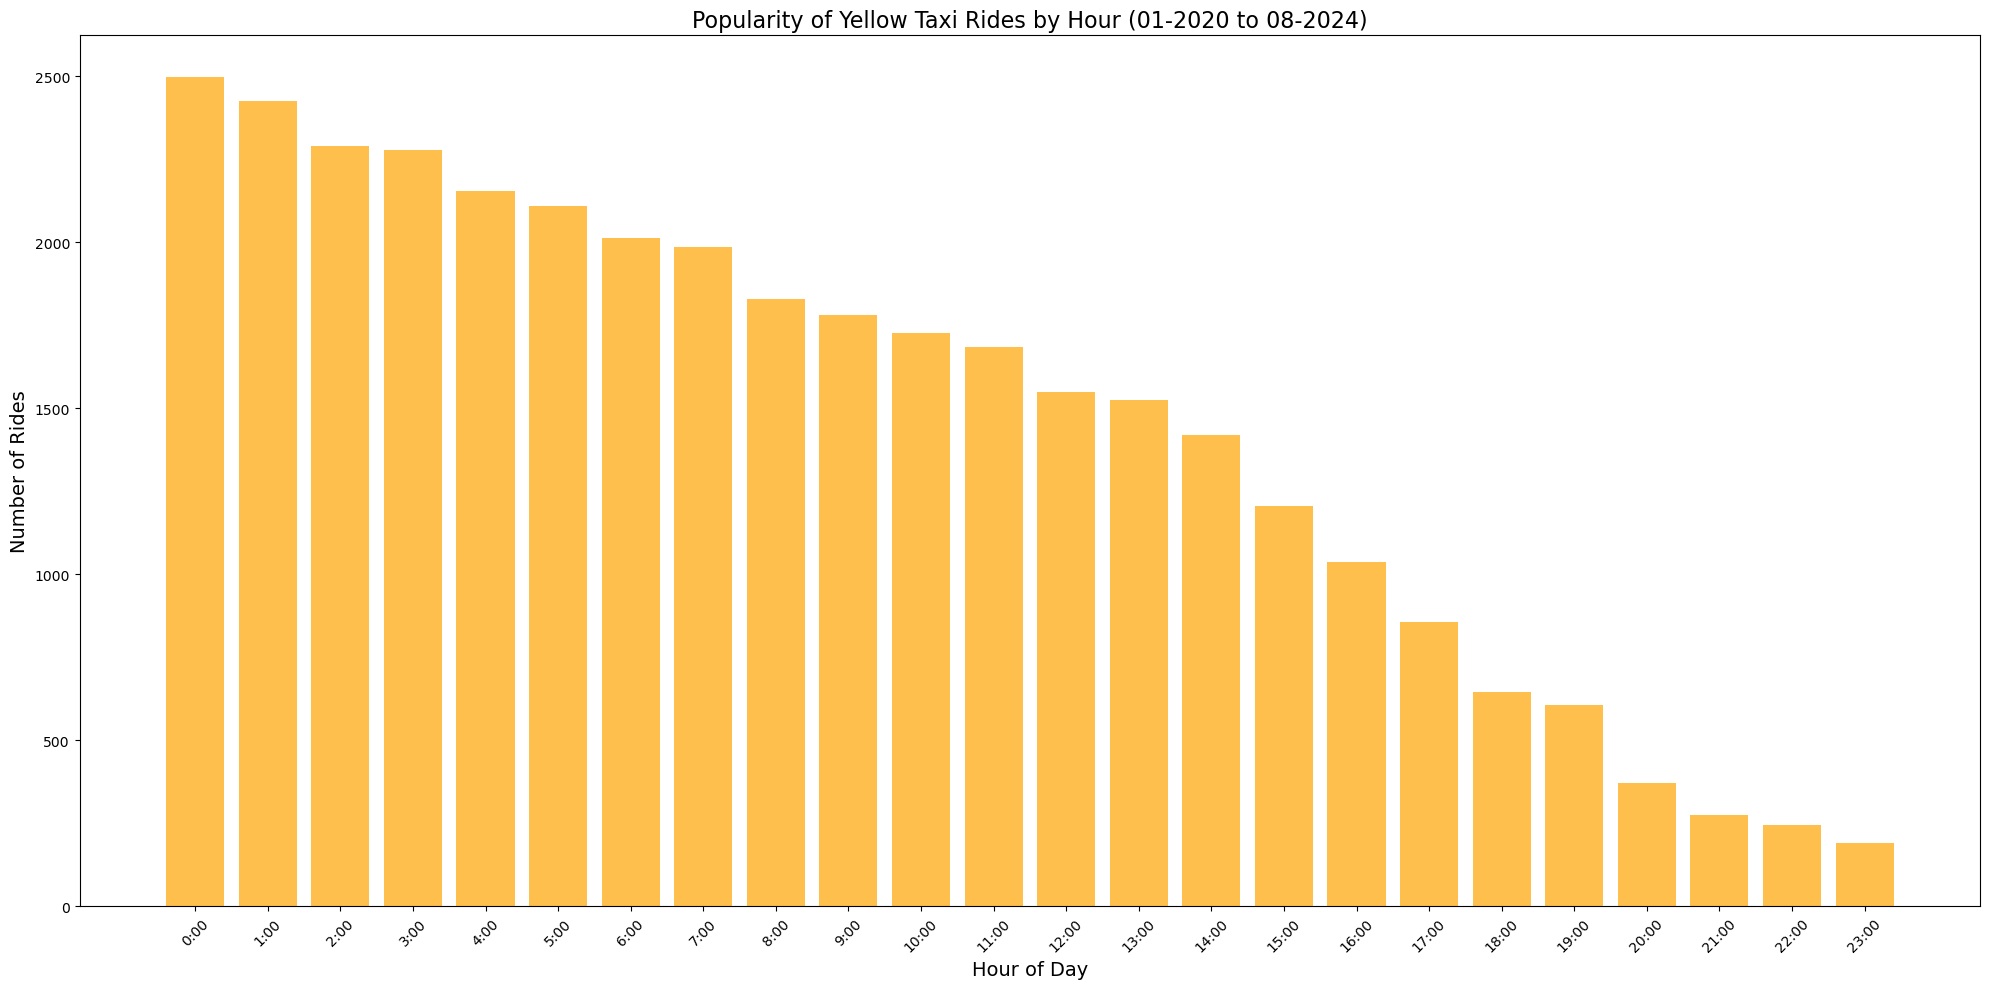

In [593]:
some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)

### 4.2 Visualization 2: The Most Popular month to hire a cab or Uber (We think it is better to use Bar chart with 90% confidence interval for this visualization)

In [599]:
def get_data_for_visual_2(engine):
    query = """
    SELECT
        strftime('%Y-%m', pickup_datetime) AS year_month,   
        SUM(trip_distance) / COUNT(*) AS avg_trip_distance   
    FROM
        (SELECT pickup_datetime, trip_distance FROM taxi_trips
         UNION ALL
         SELECT pickup_datetime, trip_distance FROM uber_trips) AS combined_trips
    WHERE
        pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'  
    GROUP BY
        strftime('%Y-%m', pickup_datetime)  -- Group by Year-Month
    ORDER BY
        year_month; 
    """
    # Fetch the data as a DataFrame
    dataframe = pd.read_sql(query, con=engine)
    return dataframe

In [601]:
def plot_visual_2(dataframe):
    # Add a 'Month' column (ignoring year)
    dataframe['Month'] = pd.to_datetime(dataframe['year_month']).dt.month_name()

    # Group by month and calculate statistics
    grouped = dataframe.groupby('Month').agg(
        mean_distance=('avg_trip_distance', 'mean'),
        std_distance=('avg_trip_distance', 'std'),
        count=('avg_trip_distance', 'count')
    ).reset_index()

    # Sort months in calendar order
    grouped['Month'] = pd.Categorical(
        grouped['Month'],
        categories=[
            "January", "February", "March", "April", "May", "June", 
            "July", "August", "September", "October", "November", "December"
        ],
        ordered=True
    )
    grouped = grouped.sort_values('Month')

    # Calculate 90% confidence intervals
    z = norm.ppf(0.95)  # z-score for 90% confidence
    grouped['ci_lower'] = grouped['mean_distance'] - z * (grouped['std_distance'] / grouped['count']**0.5)
    grouped['ci_upper'] = grouped['mean_distance'] + z * (grouped['std_distance'] / grouped['count']**0.5)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=grouped,
        x='Month',
        y='mean_distance',
        ci=None,
        color='skyblue'
    )

    # Add error bars for confidence intervals
    plt.errorbar(
        grouped['Month'],
        grouped['mean_distance'],
        yerr=[grouped['mean_distance'] - grouped['ci_lower'], grouped['ci_upper'] - grouped['mean_distance']],
        fmt='none',
        ecolor='black',
        capsize=5
    )

    # Add labels and title
    plt.title('Average Trip Distance per Month (2020-2024)', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Average Distance (miles)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show plot
    plt.show()

C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\991706140.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


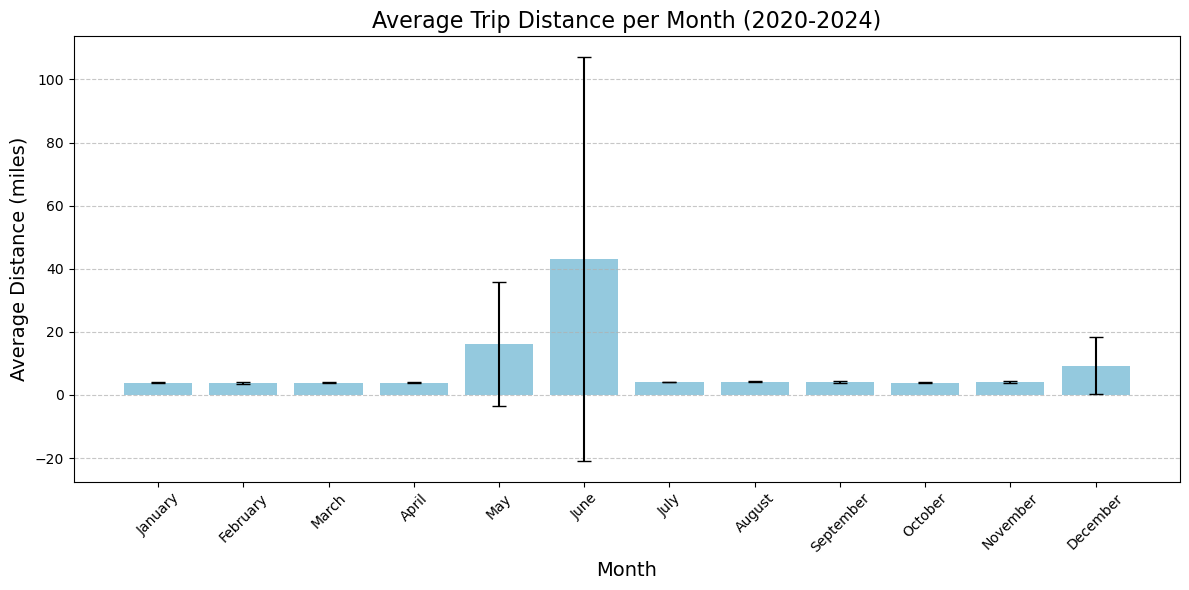

In [603]:
data = get_data_for_visual_2(engine)

# Create visualization
plot_visual_2(data)

### 4.3 Visualization 3: The Most Popular day of the week for taking a ride to an NYC-based airport. We used the Pie chart because we have data for seven days. 

In [606]:
def get_data_for_visual_3(engine):
   
    query = """
    WITH CombinedTrips AS (
        SELECT 
            dropoff_datetime, 
            dropoff_lat, 
            dropoff_lon 
        FROM taxi_trips
        UNION ALL
        SELECT 
            dropoff_datetime, 
            dropoff_lat, 
            dropoff_lon 
        FROM uber_trips
    ),
    AirportTrips AS (
        SELECT 
            dropoff_datetime,
            CASE
                WHEN dropoff_lat BETWEEN 40.763589 AND 40.778865 
                     AND dropoff_lon BETWEEN -73.891745 AND -73.854838 THEN 'LGA'
                WHEN dropoff_lat BETWEEN 40.639263 AND 40.651376 
                     AND dropoff_lon BETWEEN -73.795642 AND -73.766264 THEN 'JFK'
                WHEN dropoff_lat BETWEEN 40.686794 AND 40.699680 
                     AND dropoff_lon BETWEEN -74.194028 AND -74.165205 THEN 'EWR'
                ELSE NULL
            END AS Airport
        FROM CombinedTrips
    ),
    FilteredTrips AS (
        SELECT 
            dropoff_datetime, 
            Airport
        FROM AirportTrips
        WHERE Airport IS NOT NULL
          AND dropoff_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    SELECT 
        strftime('%w', dropoff_datetime) AS DayOfWeek,
        COUNT(*) AS TripCount
    FROM FilteredTrips
    GROUP BY 
        strftime('%w', dropoff_datetime)
    ORDER BY 
        DayOfWeek;
    """
    # Fetch data as DataFrame
    dataframe = pd.read_sql(query, con=engine)

    # Convert day of the week from numeric to names
    day_map = {
        '0': 'Sunday', '1': 'Monday', '2': 'Tuesday', '3': 'Wednesday',
        '4': 'Thursday', '5': 'Friday', '6': 'Saturday'
    }
    dataframe['DayOfWeek'] = dataframe['DayOfWeek'].map(day_map)

    return dataframe

In [614]:
conn = sqlite3.connect('project.db')

# Call the function to get the DataFrame
dataframe = get_data_for_visual_3(conn)


In [769]:
def plot_most_popular_day_for_airport_trips(dataframe):
    """
    Visualizes the most popular day of the week for trips to NYC airports (LGA, JFK, EWR) between 2020-2024.
    The input dataframe should contain 'DayOfWeek' and 'TripCount' columns.
    """
    # Check if the dataframe has the necessary columns
    if 'DayOfWeek' not in dataframe or 'TripCount' not in dataframe:
        print("Error: DataFrame must contain 'DayOfWeek' and 'TripCount' columns.")
        return

    # Prepare the data for the pie chart
    day_of_week = dataframe['DayOfWeek']
    trip_count = dataframe['TripCount']

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(trip_count, labels=day_of_week, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

    # Add title
    plt.title('Most Popular Day of the Week for NYC Airport Trips (2020-2024)', fontsize=16)

    # Display the plot
    plt.tight_layout()
    plt.show()

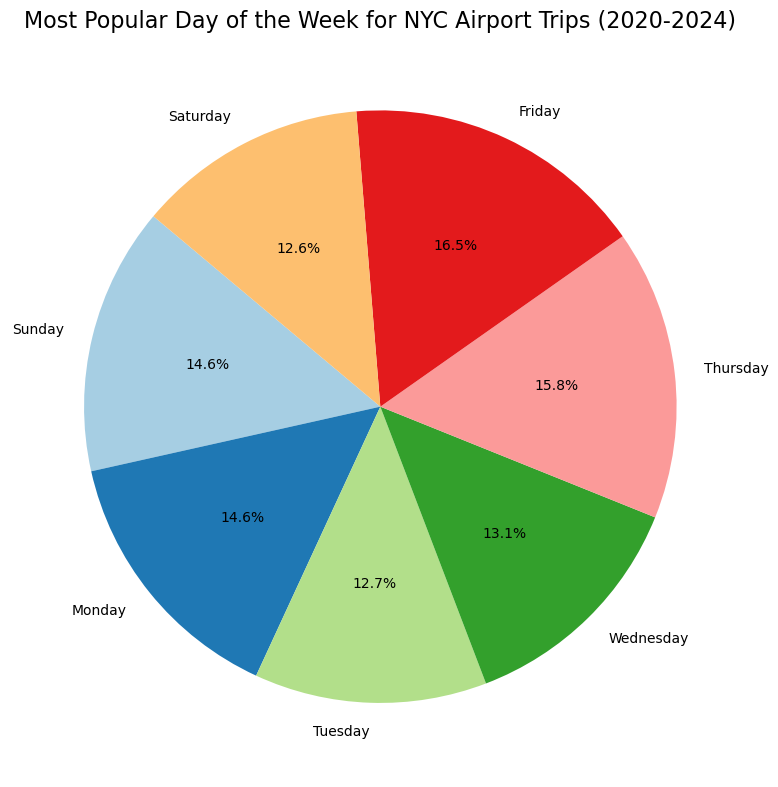

In [771]:
dataframe = get_data_for_visual_3(conn)

# Visualize the most popular day
plot_most_popular_day_for_airport_trips(dataframe)

### 4.4 Visualization 4 : How much do hired rides earn in total fares monthly? We used the Grouped Bar chart for each service of Uber and Yellow Taxi because total fare amount include other fees

In [621]:
def get_data_for_visual_4(engine):

    query = """
    SELECT
        strftime('%Y-%m', pickup_datetime) AS year_month,
        'Yellow Taxi' AS service,
        SUM(base_fare) AS base_fare,
        SUM(all_surcharges) AS all_surcharges,
        SUM(taxes) AS taxes,
        SUM(tolls) AS tolls,
        SUM(total_fare) AS total_fare
    FROM
        taxi_trips
    WHERE
        pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY
        strftime('%Y-%m', pickup_datetime)
    
    UNION ALL

    SELECT
        strftime('%Y-%m', pickup_datetime) AS year_month,
        'Uber' AS service,
        SUM(base_fare) AS base_fare,
        SUM(all_surcharges) AS all_surcharges,
        SUM(taxes) AS taxes,
        SUM(tolls) AS tolls,
        SUM(total_fare) AS total_fare
    FROM
        uber_trips
    WHERE
        pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY
        strftime('%Y-%m', pickup_datetime)
    
    ORDER BY
        year_month, service;
    """
    # Fetch the data as a DataFrame
    dataframe = pd.read_sql(query, con=engine)
    return dataframe

In [623]:
conn = sqlite3.connect('project.db')

# Call the function to get the DataFrame
dataframe4 = get_data_for_visual_4(conn)

In [625]:
def plot_visual_4(dataframe):
    """
    Creates a grouped bar chart comparing total fares with breakdown
    (base fare, surcharges, taxes, tolls) for Yellow Taxis and Ubers.

    Args:
        dataframe (pd.DataFrame): DataFrame with aggregated fare data.
    """
    # Convert 'year_month' to datetime for sorting
    dataframe['year_month'] = pd.to_datetime(dataframe['year_month'])

    # Sort data by 'year_month'
    dataframe = dataframe.sort_values(by='year_month')

    # Set up the figure
    plt.figure(figsize=(18, 10))

    # Create a categorical x-axis with Uber and Yellow Taxi side-by-side for each month
    categories = dataframe['year_month'].dt.strftime('%Y-%m').unique()
    x = range(len(categories))  # Numerical positions for the x-axis
    width = 0.4  # Width of each bar

    # Filter data for Yellow Taxi and Uber
    taxi_data = dataframe[dataframe['service'] == 'Yellow Taxi']
    uber_data = dataframe[dataframe['service'] == 'Uber']

    # Plot for Yellow Taxi
    plt.bar(
        [pos - width / 2 for pos in x], taxi_data['base_fare'],
        width=width, label='Yellow Taxi - Base Fare', color='blue'
    )
    plt.bar(
        [pos - width / 2 for pos in x], taxi_data['all_surcharges'],
        bottom=taxi_data['base_fare'], width=width, label='Yellow Taxi - Surcharges', color='orange'
    )
    plt.bar(
        [pos - width / 2 for pos in x], taxi_data['taxes'],
        bottom=taxi_data['base_fare'] + taxi_data['all_surcharges'], width=width, label='Yellow Taxi - Taxes', color='green'
    )
    plt.bar(
        [pos - width / 2 for pos in x], taxi_data['tolls'],
        bottom=taxi_data['base_fare'] + taxi_data['all_surcharges'] + taxi_data['taxes'],
        width=width, label='Yellow Taxi - Tolls', color='red'
    )

    # Plot for Uber
    plt.bar(
        [pos + width / 2 for pos in x], uber_data['base_fare'],
        width=width, label='Uber - Base Fare', color='cyan', alpha=0.7
    )
    plt.bar(
        [pos + width / 2 for pos in x], uber_data['all_surcharges'],
        bottom=uber_data['base_fare'], width=width, label='Uber - Surcharges', color='yellow', alpha=0.7
    )
    plt.bar(
        [pos + width / 2 for pos in x], uber_data['taxes'],
        bottom=uber_data['base_fare'] + uber_data['all_surcharges'], width=width, label='Uber - Taxes', color='lime', alpha=0.7
    )
    plt.bar(
        [pos + width / 2 for pos in x], uber_data['tolls'],
        bottom=uber_data['base_fare'] + uber_data['all_surcharges'] + uber_data['taxes'],
        width=width, label='Uber - Tolls', color='pink', alpha=0.7
    )

    # Add titles, labels, and legend
    plt.title('Monthly Total Fares with Breakdown: Yellow Taxis vs Uber', fontsize=16)
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('Fare Amount ($)', fontsize=12)

    # Customize x-axis ticks
    plt.xticks(x, categories, rotation=45)

    # Adjust legend and layout
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

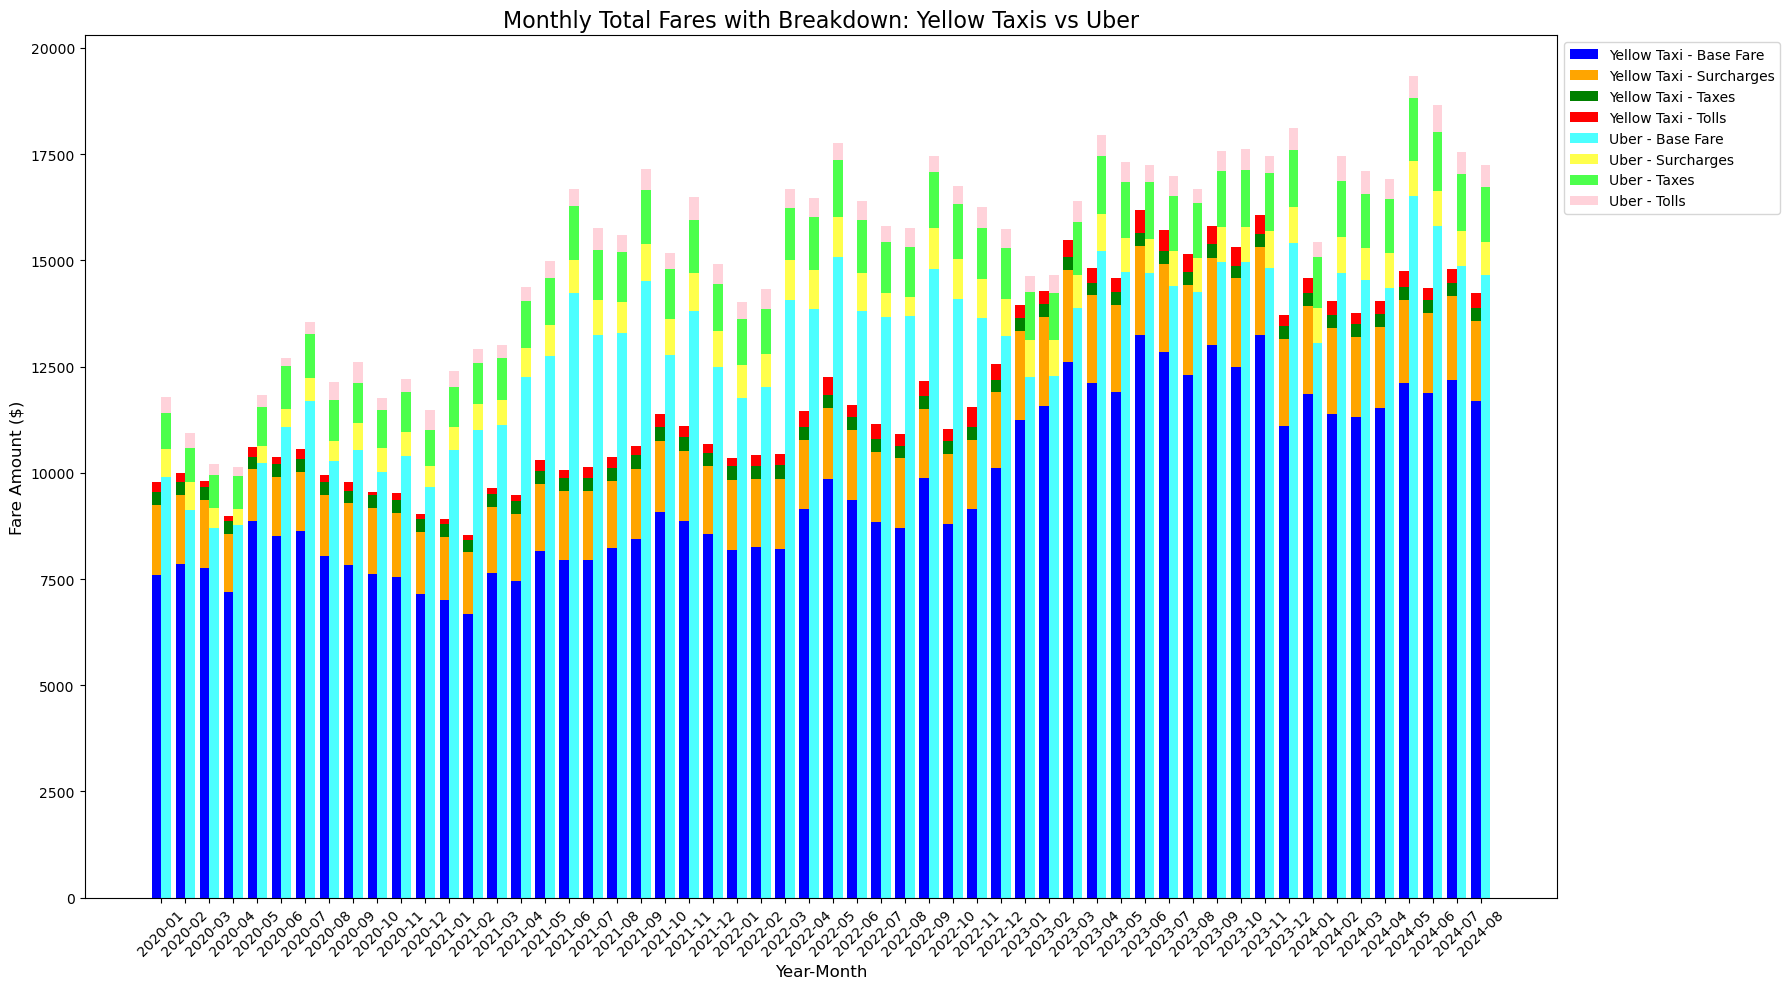

In [627]:
plot_visual_4(dataframe4)

### 4.5 Visualization 5: Does precipitation or distance traveled affect the amount of tip?

#### I chose scatter plot to better show the distribution of tips amount verses trip distance and preciputation for taxi and uber

In [630]:
def plot_visual_5(df_taxi: pd.DataFrame, df_uber: pd.DataFrame) -> None:
    # Create the 2x2 figure layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Identify and remove outlier in the 'trip_distance' column (longest distance) from df_taxi
    max_distance_taxi = df_taxi['trip_distance'].max()
    df_taxi_without_outlier = df_taxi[df_taxi['trip_distance'] != max_distance_taxi]
    
    # Plot 1: Tips vs. Trip Distance (Yellow Taxi)
    axes[0, 0].scatter(df_taxi_without_outlier['trip_distance'], df_taxi_without_outlier['tips'], color='yellow', alpha=0.5)
    axes[0, 0].set_title('Tips vs. Trip Distance (Yellow Taxi) Without outliers')
    axes[0, 0].set_xlabel('Trip Distance')
    axes[0, 0].set_ylabel('Tips')

    # Plot 2: Tips vs. Trip Distance (Uber)
    axes[0, 1].scatter(df_uber['trip_distance'], df_uber['tips'], color='blue', alpha=0.5)
    axes[0, 1].set_title('Tips vs. Trip Distance (Uber)')
    axes[0, 1].set_xlabel('Trip Distance')
    axes[0, 1].set_ylabel('Tips')

    # Plot 3: Tips vs. Precipitation (Yellow Taxi)
    axes[1, 0].scatter(df_taxi['hourlyprecipitation'], df_taxi['tips'], color='yellow', alpha=0.5)
    axes[1, 0].set_title('Tips vs. Precipitation (Yellow Taxi)')
    axes[1, 0].set_xlabel('Hourly Precipitation')
    axes[1, 0].set_ylabel('Tips')

    # Plot 4: Tips vs. Precipitation (Uber)
    axes[1, 1].scatter(df_uber['hourlyprecipitation'], df_uber['tips'], color='blue', alpha=0.5)
    axes[1, 1].set_title('Tips vs. Precipitation (Uber)')
    axes[1, 1].set_xlabel('Hourly Precipitation')
    axes[1, 1].set_ylabel('Tips')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    plt.show()

In [635]:
def get_data_for_visual_5():
    conn = sqlite3.connect('project.db')
    
    # Query for Yellow Taxi data
    query_taxi = """
    SELECT tips, trip_distance, pickup_datetime, hourlyprecipitation
    FROM taxi_trips
    LEFT JOIN hourly_weather
    ON strftime('%Y-%m', taxi_trips.pickup_datetime) = strftime('%Y-%m', hourly_weather.dateonly)
    WHERE strftime('%Y', taxi_trips.pickup_datetime) IN ('2022', '2023');
    """
    
    # Query for Uber data
    query_uber = """
    SELECT tips, trip_distance, pickup_datetime, hourlyprecipitation
    FROM uber_trips
    LEFT JOIN hourly_weather
    ON strftime('%Y-%m', uber_trips.pickup_datetime) = strftime('%Y-%m', hourly_weather.dateonly)
    WHERE strftime('%Y', uber_trips.pickup_datetime) IN ('2022', '2023');
    """
    
    # Fetch and combine the data into dataframes
    df_taxi = pd.read_sql(query_taxi, conn)
    df_uber = pd.read_sql(query_uber, conn)
    
    # Close the connection
    conn.close()
    
    return df_taxi, df_uber

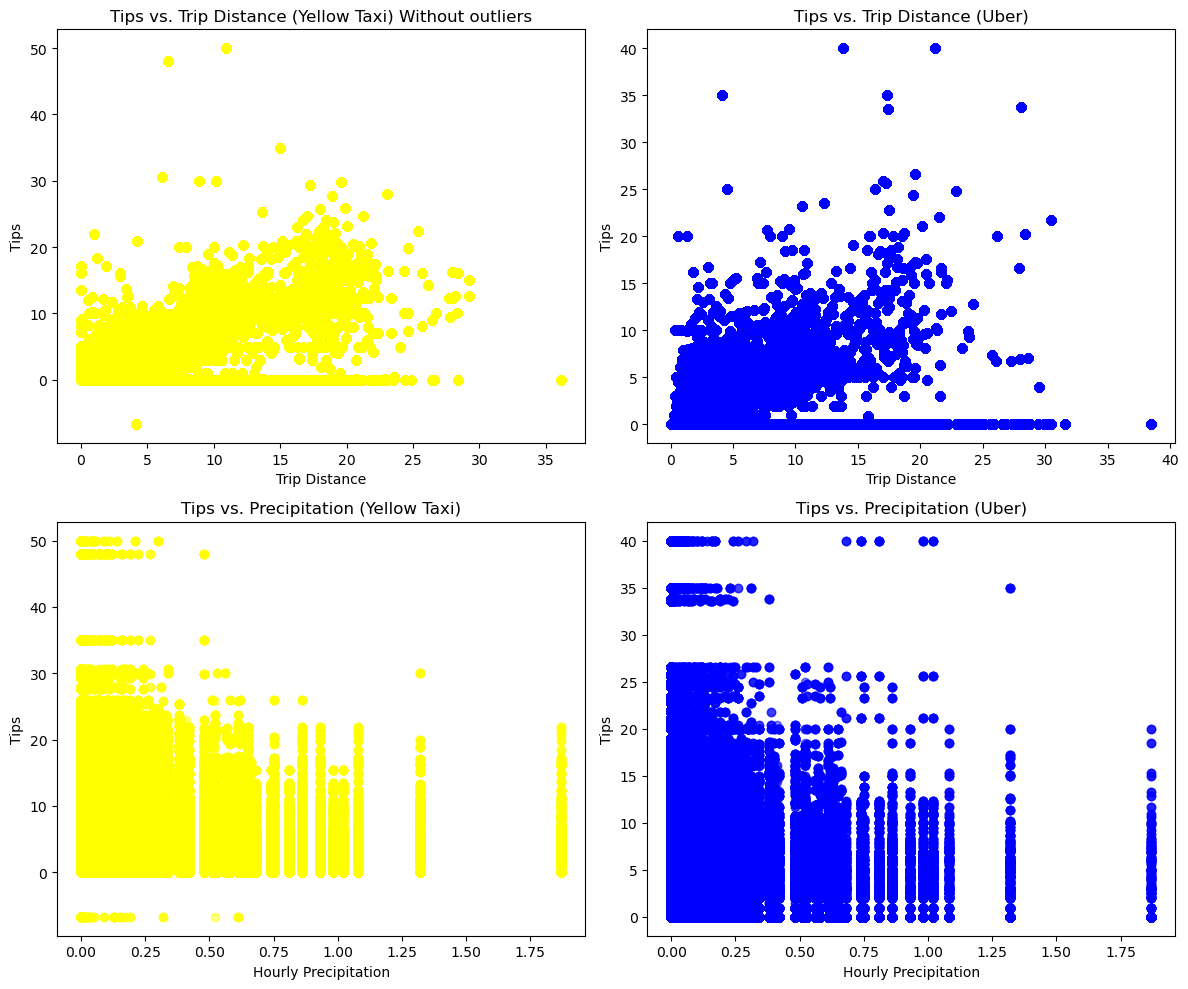

In [634]:
df_taxi, df_uber = get_data_for_visual_5()
plot_visual_5(df_taxi,df_uber)

### 4.6  Visualization 6: Heatmap of all hired trips in 2020 over a map of the area   (I chose to show all hired trips in 2020 over a map of the area using heatmap to better show which areas require more taxi/uber rised/ most visited. )

In [645]:

import folium
from folium.plugins import HeatMap
from IPython.display import display

In [647]:
def plot_visual_6(dataframe: pd.DataFrame) -> None:
    # Create a base map centered around the average latitude and longitude of the trips
    map_center = [dataframe['pickup_lat'].mean(), dataframe['pickup_lon'].mean()]
    mymap = folium.Map(location=map_center, zoom_start=12)

    # Prepare the heatmap data
    heat_data = [[row['pickup_lat'], row['pickup_lon']] for index, row in dataframe.iterrows()]
    
    # Create the heatmap
    HeatMap(heat_data).add_to(mymap)

    # Display the map directly in the Jupyter Notebook
    display(mymap)

In [651]:
def get_data_for_visual_6() -> pd.DataFrame:

    conn = sqlite3.connect('project.db')
    
    # Query to extract the relevant data for taxi and uber trips in 2020
    query_taxi = """
    SELECT pickup_lat, pickup_lon
    FROM taxi_trips
    WHERE strftime('%Y', pickup_datetime) = '2020';
    """
    
    query_uber = """
    SELECT pickup_lat, pickup_lon
    FROM uber_trips
    WHERE strftime('%Y', pickup_datetime) = '2020';
    """
    
    # Read data into pandas DataFrames
    df_taxi = pd.read_sql(query_taxi, conn)
    df_uber = pd.read_sql(query_uber, conn)
    
    # Combine both datasets
    df_combined = pd.concat([df_taxi, df_uber], ignore_index=True)
    
    # Filter out any rows with missing latitude or longitude (we've already done this when cleaning the data)
    df_combined = df_combined.dropna(subset=['pickup_lat', 'pickup_lon'])
    
    return df_combined

In [653]:
visual6_dataframe = get_data_for_visual_6()
plot_visual_6(visual6_dataframe)

## Part 5: Extra Credit Sunrise Sunset

### 5.1 Process the Data and Achieve Dataset

In [791]:
directory = WEATHER_CSV_DIR
output_directory = WEATHER_CSV_DIR

In [793]:
def get_raw_weather_data_again(directory: str) -> List[str]:
    # Ensure the directory exists
    if not os.path.isdir(directory):
        raise ValueError(f"The provided path is not a valid directory: {directory}")
    
    # List all files in the directory and filter for .csv files that do not contain 'cleaned' in their name
    csv_files = [
        f for f in os.listdir(directory) 
        if f.endswith('.csv') and 'cleaned' not in f.lower() and os.path.isfile(os.path.join(directory, f))
    ]
    
    # Return the full path to each valid CSV file
    return [os.path.join(directory, f) for f in csv_files]

In [795]:
get_raw_weather_data_again(directory)

['./raw_weather_data\\2020_weather.csv',
 './raw_weather_data\\2021_weather.csv',
 './raw_weather_data\\2022_weather.csv',
 './raw_weather_data\\2023_weather.csv',
 './raw_weather_data\\2024_weather.csv']

In [797]:
def clean_sunrise_sunset_data(csv_file: str, output_directory: str) -> None:
    df = pd.read_csv(csv_file)
    # Make sure the columns are in the correct format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Filter rows with non-null entries for both sunrise and sunset
    filtered_df = df.dropna(subset=['Sunrise', 'Sunset'])

    # Extract dateonly from 'DATE'
    filtered_df['dateonly'] = filtered_df['DATE'].dt.date

    # Extract hour part from sunrise and sunset
    filtered_df['sunrisehour'] = filtered_df['Sunrise'].apply(lambda x: str(int(x) // 100))  # Hour part of sunrise
    filtered_df['sunsethour'] = filtered_df['Sunset'].apply(lambda x: str(int(x) // 100))  # Hour part of sunset

    # Select only the required columns, and ensure the column names are lowercase
    final_df = filtered_df[['dateonly', 'Sunrise', 'Sunset', 'sunrisehour', 'sunsethour']]
    final_df.columns = final_df.columns.str.lower()

    # Generate a new CSV file with the cleaned data
    output_filename = csv_file.replace('.csv', '_sunset_sunrise.csv')
    final_df.to_csv(output_filename, index=False)
    print(f"Sunset sunrise data saved to {output_filename}")

In [799]:
# create cleaned files seperately:
input_directory = WEATHER_CSV_DIR
output_directory = input_directory  # Folder where the cleaned files will be saved

# Get all CSV files in the folder
csv_files_1 = get_raw_weather_data_again(input_directory)

# Check if multiple files are found
if len(csv_files) == 0:
    print("No CSV files found in the directory.")
else:
    # Process each CSV file
    for csv_file in csv_files_1:
        print(f"Processing file: {csv_file}")  # Debug: show which file is being processed
        cleaned_data = clean_sunrise_sunset_data(csv_file, output_directory)

        # Optionally, print the cleaned data to verify
        print(f"Cleaned sunrise sunset data saved for: {csv_file}")

Processing file: ./raw_weather_data\2020_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:2: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sunr

Sunset sunrise data saved to ./raw_weather_data\2020_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2020_weather.csv
Processing file: ./raw_weather_data\2021_weather.csv
Sunset sunrise data saved to ./raw_weather_data\2021_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2021_weather.csv
Processing file: ./raw_weather_data\2022_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sunrisehour'] = filtered_df['Sunrise'].apply(lambda x: str(int(x) // 100))  # Hour part of sunrise
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:14: SettingWithCopyWarning: 
A value is trying to be s

Sunset sunrise data saved to ./raw_weather_data\2022_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2022_weather.csv
Processing file: ./raw_weather_data\2023_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:2: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sunri

Sunset sunrise data saved to ./raw_weather_data\2023_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2023_weather.csv
Processing file: ./raw_weather_data\2024_weather.csv
Sunset sunrise data saved to ./raw_weather_data\2024_weather_sunset_sunrise.csv
Cleaned sunrise sunset data saved for: ./raw_weather_data\2024_weather.csv


C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:2: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dateonly'] = filtered_df['DATE'].dt.date
C:\Users\sanch\AppData\Local\Temp\ipykernel_70472\2528548913.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [801]:
def merge_cleaned_sunrise_sunset_files(input_directory: str, output_filename: str) -> None:
    # Get all CSV files in the directory that end with "sunset_sunrise"
    cleaned_sunrise_sunset_files = [f for f in os.listdir(input_directory) if  f.endswith('sunset_sunrise.csv')]
    
    # Check if we found any files
    if not cleaned_sunrise_sunset_files:
        print(f"No CSV files found in {input_directory} that end with 'sunrise_sunset'.")
        return

    # Initialize a list to hold all DataFrames
    all_cleaned_sunrise_sunset_data = []

    # Read each cleaned file and append it to the list
    for cleaned_sunrise_sunset_file in cleaned_sunrise_sunset_files:
        file_path_1 = os.path.join(input_directory, cleaned_sunrise_sunset_file)
        print(f"Reading file: {file_path_1}")  # Debug: show which file is being processed
        
        # Read the CSV file into a DataFrame
        cleaned_sunrise_sunset_data = pd.read_csv(file_path_1)
        
        # Append the DataFrame to the list
        all_cleaned_sunrise_sunset_data.append(cleaned_sunrise_sunset_data)

    # Merge all the DataFrames into one
    merged_sunrise_sunset_data = pd.concat(all_cleaned_sunrise_sunset_data, ignore_index=True)

    # Define the output file path
    output_file_path = os.path.join(input_directory, output_filename)

    # Save the merged DataFrame to a new CSV file
    merged_sunrise_sunset_data.to_csv(output_file_path, index=False)
    
    # Debug: Confirm the merged file is saved
    print(f"All cleaned data merged and saved to: {output_file_path}")

In [803]:
input_directory = WEATHER_CSV_DIR
output_filename = "cleaned_sunrise_sunset.csv"
merge_cleaned_sunrise_sunset_files(input_directory, output_filename)

Reading file: ./raw_weather_data\2020_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2021_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2022_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2023_weather_sunset_sunrise.csv
Reading file: ./raw_weather_data\2024_weather_sunset_sunrise.csv
All cleaned data merged and saved to: ./raw_weather_data\cleaned_sunrise_sunset.csv


In [805]:
sunrise_sunset_data = pd.read_csv(r'./raw_weather_data/cleaned_sunrise_sunset.csv')
sunrise_sunset_data.head()

,dateonly,sunrise,sunset,sunrisehour,sunsethour
0,2020-01-01,720.0,1639.0,7,16
1,2020-01-02,720.0,1640.0,7,16
2,2020-01-03,720.0,1641.0,7,16
3,2020-01-04,720.0,1642.0,7,16
4,2020-01-05,720.0,1643.0,7,16


In [807]:
sunrise_sunset_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dateonly     1755 non-null   object 
 1   sunrise      1755 non-null   float64
 2   sunset       1755 non-null   float64
 3   sunrisehour  1755 non-null   int64  
 4   sunsethour   1755 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 68.7+ KB


In [809]:
sunrise_sunset_data.describe()

,sunrise,sunset,sunrisehour,sunsethour
count,1755.000000,1755.000000,1755.000000,1755.000000
mean,559.546439,1789.639316,5.309972,17.604558
std,101.696961,104.053733,1.076698,1.093560
min,424.000000,1628.000000,4.000000,16.000000
25%,451.000000,1710.000000,4.000000,17.000000
50%,543.000000,1809.000000,5.000000,18.000000
75%,643.500000,1904.000000,6.000000,19.000000
max,720.000000,1931.000000,7.000000,19.000000


### Part 6: Extra Credit  Animation

In [844]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

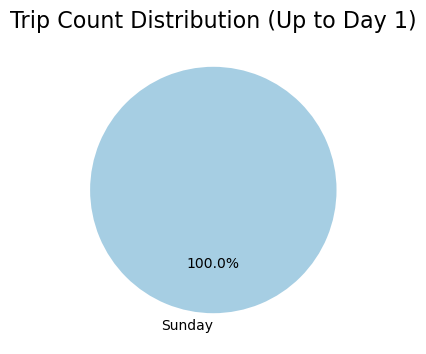

In [728]:
dataframe = get_data_for_visual_3(conn)
df = pd.DataFrame(dataframe)

# Prepare the figure for the animation
fig, ax = plt.subplots(figsize=(6, 4))

# Initial Pie Chart (empty)
def update(frame):
    # Clear the previous plot
    ax.clear()

    # Data for the current frame
    current_data = df.iloc[:frame+1]

    # Plot the pie chart with the current data
    ax.pie(current_data['TripCount'], labels=current_data['DayOfWeek'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    
    # Add a title
    ax.set_title(f"Trip Count Distribution (Up to Day {frame+1})", fontsize=16)

    return ax.patches

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(df), interval=1000, blit=False
)

# Display the animation inline in Jupyter Notebook
display(HTML(ani.to_jshtml()))

# Optionally, save the animation
ani.save("trip_count_pie_animation.mp4", writer="ffmpeg", fps=1)